# PXD013277

## Human cell lysate with added E. coli

### Data analysis performed by Phil Wilmarth, PSR Core OHSU

#### June 16, 2020

---

- [Overview](#overview) 
- [Library and data loading](#load_data) 
- [Clustering and normalization](#TMM)
- [1. 7.5 versus 15 (2-fold)](#7pt5_15) 
- [2. 7.5 versus 45 (6-fold)](#7pt5_45) 
- [3. 15 versus 45 (3-fold)](#15_45) 
- [Summary](#summary)

---

## <a name="overview"></a>Overview

The data is from the [PXD013277](http://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD013277) PRIDE archive. The human cells are the MCF7 cell line. E. coli lysate was spiked in at 3 different relative levels. The mixes were labeled with TMT 10-plex and analyzed in a large-scale fractionation using a Q Exactive HF instrument. The human samples and the E. coli samples are replicates of one cell lysate pellet. I think the digestions and labeling reactions are all independent. We will have some experimental variation, but not as much as true independent biological replicates. 

Sample Key:

Channel|E. coli (ug)|MCF7 (ug)|Total (ug)|Human Fraction
-------|------------|---------|----------|--------------
126C|7.5|70|77.5|0.90
127N|7.5|70|77.5|0.90
127C|7.5|70|77.5|0.90
128N|15|70|85|0.82
128C|15|70|85|0.82
129N|15|70|85|0.82
129C|15|70|85|0.82
130N|45|70|115|0.61
130C|45|70|115|0.61
131N|45|70|115|0.61 

The data is described in [this MCP paper](https://www-mcponline-org.liboff.ohsu.edu/content/mcprot/early/2020/03/23/mcp.TIR119.001646.full.pdf) (free ahead of press). Briefly, samples were reduced and alkylated, digested with LysC and trypsin in an SP3 bead protocol. The first-dimension separation was a peptide IEF-IPG method that resulted in 72 fractions. Each fraction was run on a standard reverse phase column into a Q Exactive HF instrument. Instrument parameters looked typical for an MS2 TMT experiment on this platform.

The data was downloaded from PRIDE (about 29 GB) and converted to compressed text files using [MSConvert](http://proteowizard.sourceforge.net/). The re-analysis used the [PAW pipeline](https://github.com/pwilmart/PAW_pipeline). A combined human and E. coli canonical reference proteome FASTA file was created using [fasta_utilities tools](https://github.com/pwilmart/fasta_utilities). A wide tolerance [Comet](http://comet-ms.sourceforge.net/) search (1.25 Da for parent ions) was used with recommended settings for high-resolution MS2 fragment ions. PSMs were filtered to 1% FDR. Protein inference used basic and extended parsimony analysis. TMT analysis used reporter ions from all unique (with respect to the final protein list) peptides summed into protein total intensities. Normalizations and statistical testing was done in edgeR using the [Jupyter notebook](https://jupyter.org/).

The RAW data files had 1,961,506 MS2 scans. At a 1% FDR, there were 303,201 scans that passed the score cutoffs (15.5% overall ID rate). There were about 10K protein IDs: 9,650 proteins excluding common contaminants, decoys, and proteins without any usable reporter ion signals using a two peptides per protein criterion. 

### References

> Thompson, A., Schäfer, J., Kuhn, K., Kienle, S., Schwarz, J., Schmidt, G., Neumann, T. and Hamon, C., 2003. Tandem mass tags: a novel quantification strategy for comparative analysis of complex protein mixtures by MS/MS. Analytical chemistry, 75(8), pp.1895-1904.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

---

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== p-value plots ================================================
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# ============= log2 fold-change distributions =================================
log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     results$species,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "species", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== MA plots using ggplot =============================================
MA_species <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = species, shape = species)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = species, shape = species)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ species) +
        ggtitle(str_c(title, " (separated by species)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Scatter plots using ggplot ========================================
scatter_species <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = species, shape = species)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = species, shape = species)) +
        scatter_lines +
        facet_wrap(~ species) +
        ggtitle(str_c(title, " (separated by species)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

## <a name="load_data"></a>Load the TMT intensity data

The data was gently prepped in Excel to remove contaminants, decoys, and proteins without intensities. We have an accessions column and a column to denote human or E. coli species. There are the 10 TMT channels.

In [3]:
# load the IRS-normalized data and check the table
data_all <- read_tsv("edgeR_input.txt")

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession
species <- data_all$HorE

# get just the TMT columns
data_tmt <- select(data_all, -Accession, -HorE)

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  Accession = col_character(),
  HorE = col_character(),
  A_70_7pt5 = col_double(),
  B_70_7pt5 = col_double(),
  C_70_7pt5 = col_double(),
  A_70_15 = col_double(),
  B_70_15 = col_double(),
  C_70_15 = col_double(),
  D_70_15 = col_double(),
  A_70_45 = col_double(),
  B_70_45 = col_double(),
  C_70_45 = col_double()
)



[1] 9650

### Use data from all conditions for edgeR analysis

We are defining the groups that will be compared explicitly and using all of the samples for variance estimates. We will put the data into a data frame, grouped by condition. We will define some column indexes for each condition, set some colors for plotting, and see how the data cluster by condition.

In [4]:
# define the 3 spike-in groups
low <- 1:3
med <- 4:7
high <- 8:10

# set some colors by condition
colors = c(rep('red', length(low)), rep('blue', length(med)), rep('green', length(high)))

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization. We will double check if the TMM normalization changed the clustering that we had above. 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 A_70_7pt5 -> 1.078074
 B_70_7pt5 -> 1.176160
 C_70_7pt5 -> 1.106798
 A_70_15 -> 0.924352
 B_70_15 -> 0.966140
 C_70_15 -> 0.878807
 D_70_15 -> 1.064562
 A_70_45 -> 1.005977
 B_70_45 -> 0.908258
 C_70_45 -> 0.971369

Trimmed mean of M-values (TMM) factors:
 A_70_7pt5 -> 0.934232
 B_70_7pt5 -> 0.917312
 C_70_7pt5 -> 0.923244
 A_70_15 -> 0.974557
 B_70_15 -> 0.967155
 C_70_15 -> 0.978748
 D_70_15 -> 0.962735
 A_70_45 -> 1.120056
 B_70_45 -> 1.129326
 C_70_45 -> 1.125050

Combined (lib size and TMM) normalization factors:
 A_70_7pt5 -> 1.007171
 B_70_7pt5 -> 1.078905
 C_70_7pt5 -> 1.021845
 A_70_15 -> 0.900834
 B_70_15 -> 0.934407
 C_70_15 -> 0.860131
 D_70_15 -> 1.024890
 A_70_45 -> 1.126751
 B_70_45 -> 1.025719
 C_70_45 -> 1.092838


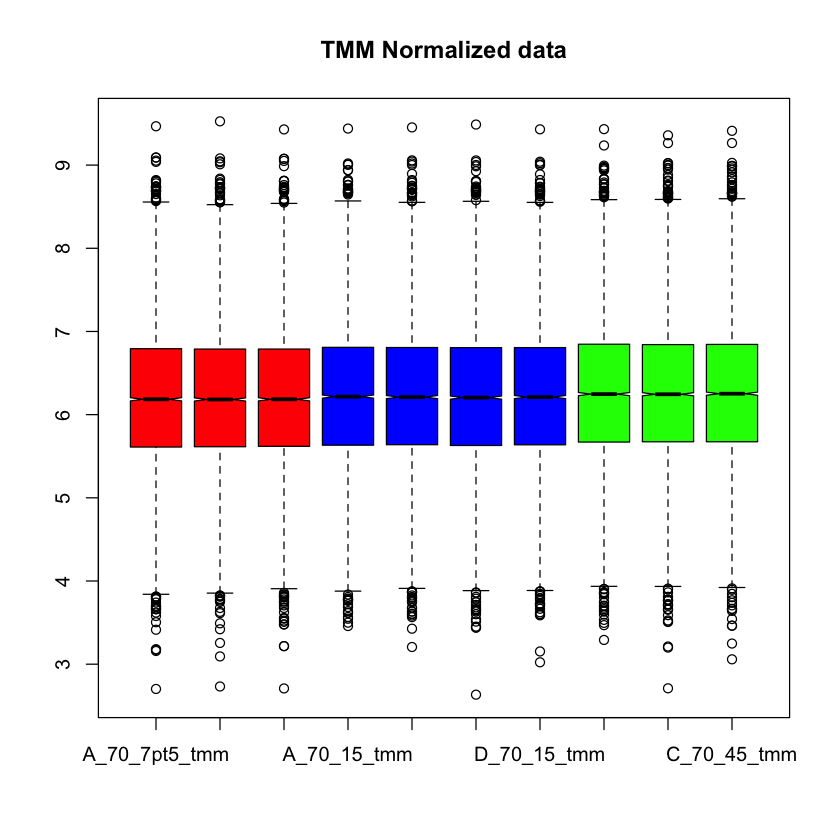

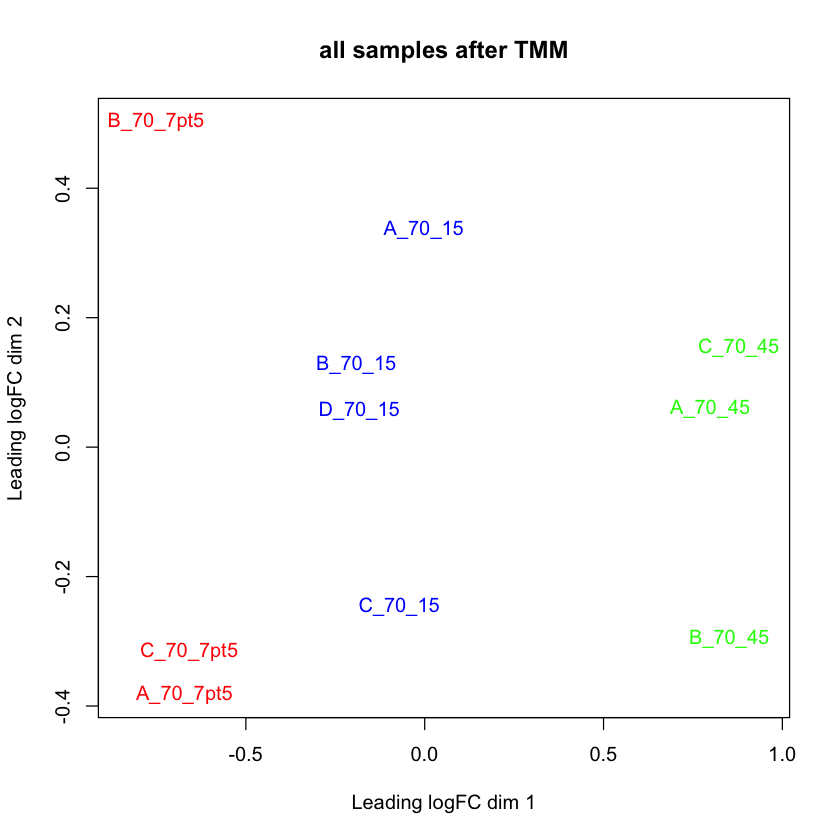

In [5]:
# get the biological sample data into a DGEList object
group = c(rep("low", length(low)), rep("med", length(med)), rep("high", length(high)))
y <- DGEList(counts = data_tmt, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

tmt_tmm <- apply_tmm_factors(y, color = colors)

# check the clustering
plotMDS(y, col = colors, main = "all samples after TMM")

### TMM factors are very close to 1.0

The IRS method already takes care of the library size type of normalizations. We could still have compositional differences between sample groups that the TMM factors would correct for. We do not have any library size or TMM factors that are much different from 1.0.

The box plots are very similar. TMM usually gets the medians (box centers) aligned pretty well. 

# EdgeR statistical testing starts here

## Compute the shared variance trend

One of the most powerful features of edgeR (and limma) is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 18 samples across all conditions to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR `estimateDisp` function that does all of this and a visualization function to check the result.

We loaded the IRS data into `DGEList` object `y` a few cells above and did the normalization step. We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take two conditions and compare them using the normalization factors and dispersion estimates saved in `y`.

Design matrix not provided. Switch to the classic mode.


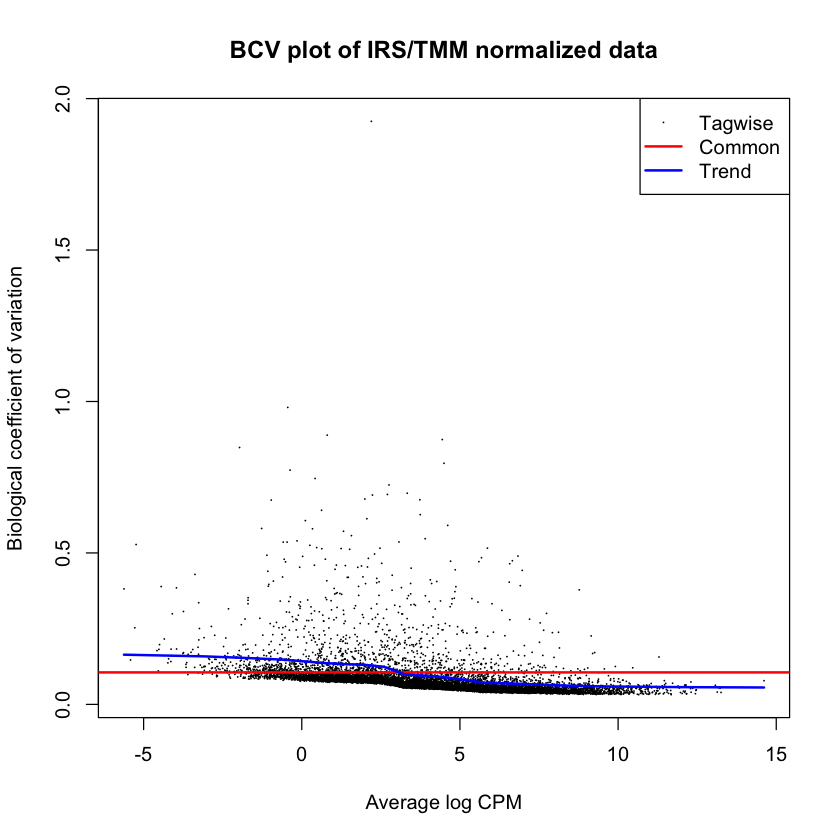

In [6]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS/TMM normalized data")

## <a name="7pt5_15"></a>(1) 7.5 versus 15 microgram E. coli

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The `decideTestsDGE` call will tell us how many up and down regulated candidates we have at an FDR of 0.10. The `topTags` call does the Benjamini-Hochberg multiple testing corrections. We save the test results in `tt`. We use a handy MA (mean-average) plotting function from `limma` to visualize the DE candidates, and then check the p-value distribution.

       med-low
Down       228
NotSig    7388
Up        2034

genes                logFC     logCPM    PValue       FDR         
158  sp|P09373|PFLB_ECOLI 0.6603534 10.039541 1.971889e-38 1.902873e-34
1046 sp|P08622|DNAJ_ECOLI 0.5837401  7.580124 3.435490e-37 1.221542e-33
862  sp|P0ADG7|IMDH_ECOLI 0.6052487  7.896581 3.797539e-37 1.221542e-33
110  sp|P60422|RL2_ECOLI  0.5968483 10.420761 6.704207e-37 1.617390e-33
1027 sp|P0A9D8|DAPD_ECOLI 0.6576326  7.600313 1.254264e-36 2.420730e-33
287  sp|P0AEM9|FLIY_ECOLI 0.6455200  9.334523 8.774429e-36 1.411221e-32
381  sp|P0A7R1|RL9_ECOLI  0.5896924  9.041035 1.449819e-35 1.850172e-32
68   sp|P0AE08|AHPC_ECOLI 0.6914900 10.946146 1.533821e-35 1.850172e-32
1532 sp|P45577|PROQ_ECOLI 0.7373451  6.870963 1.532251e-34 1.642914e-31
722  sp|P0A817|METK_ECOLI 0.5953168  8.186620 1.946672e-34 1.878538e-31

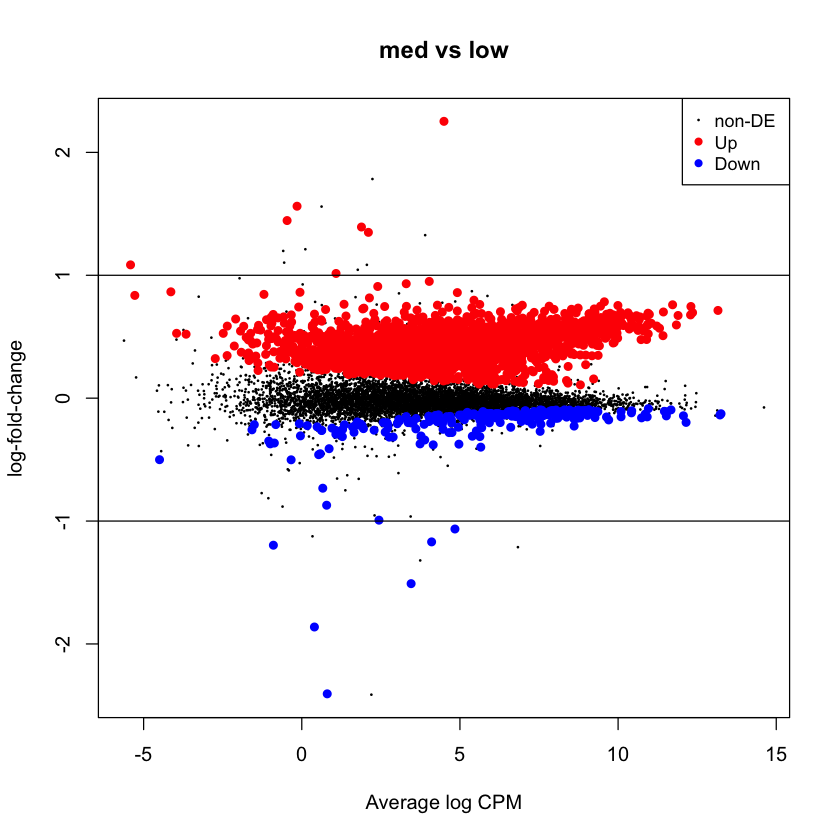

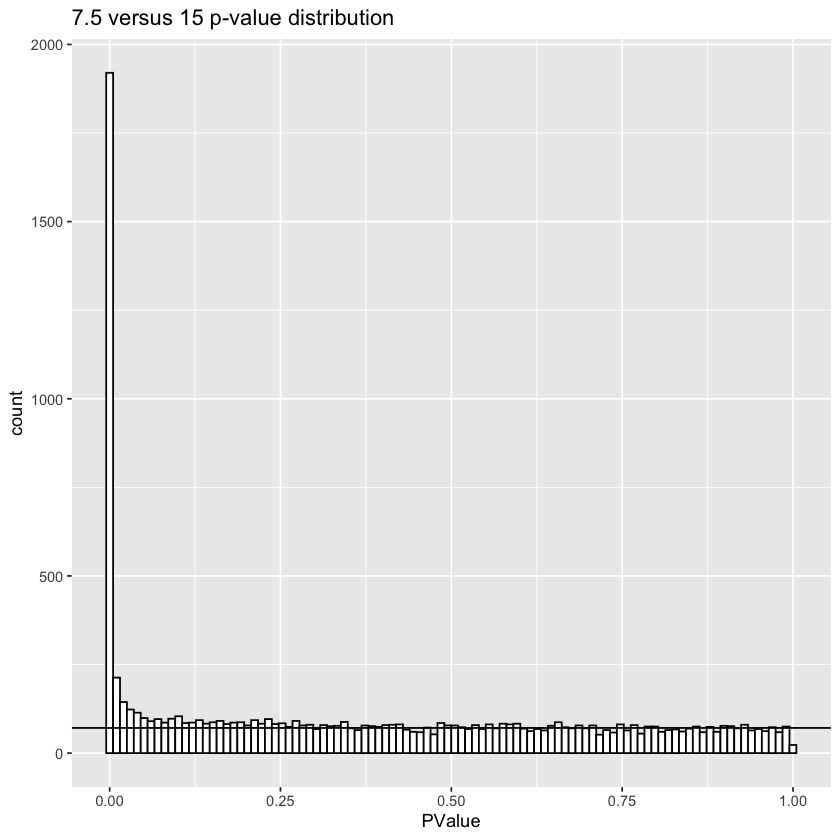

In [7]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("low", "med"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("7.5 versus 15 p-value distribution")

### We have 2,262 DE candidates

We have many candidates and most candidates are over-expressed (what we would expect the 2,091 E. coli proteins to do). We also have a couple of hundred down-regulated proteins. We do not expect that given that the human background should be the same. The p-value distribution looks typical when we have true DE candidates. 


## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

Even though we do not have many candidates, we will still make the MA plots, scatter plots, and volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

In [8]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, low, "low", med, "med")
results$species <- as.factor(species)

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_low_med")

# accumulate the testing results
all_results <- results_temp

### Count candidates and look at fold-change distributions

[1] "E. coli Summary"


candidate n   
1 high      1700
2 med        122
3 low         61
4 no         208

[1] "Human Summary"


candidate n   
1 high        92
2 med        132
3 low        155
4 no        7180

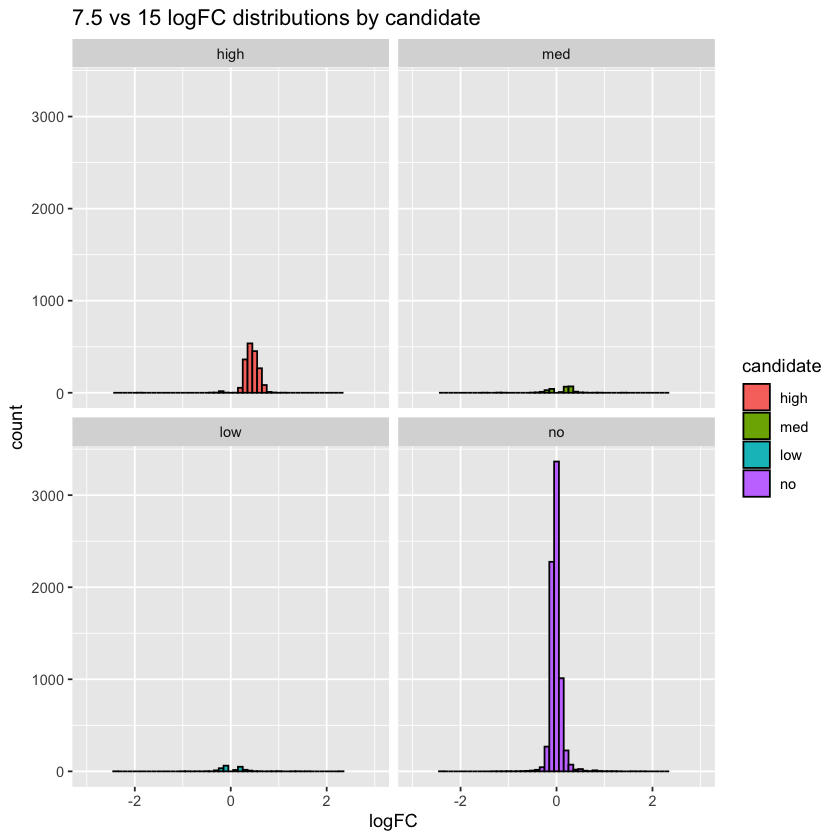

In [9]:
# see how many candidates by category
print("E. coli Summary")
results %>% filter(species == "E.coli") %>% count(candidate)

print("Human Summary")
results %>% filter(species == "human") %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("7.5 vs 15 logFC distributions by candidate")

## Main summary plots

We have many comparisons to visualize, so we will use functions to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

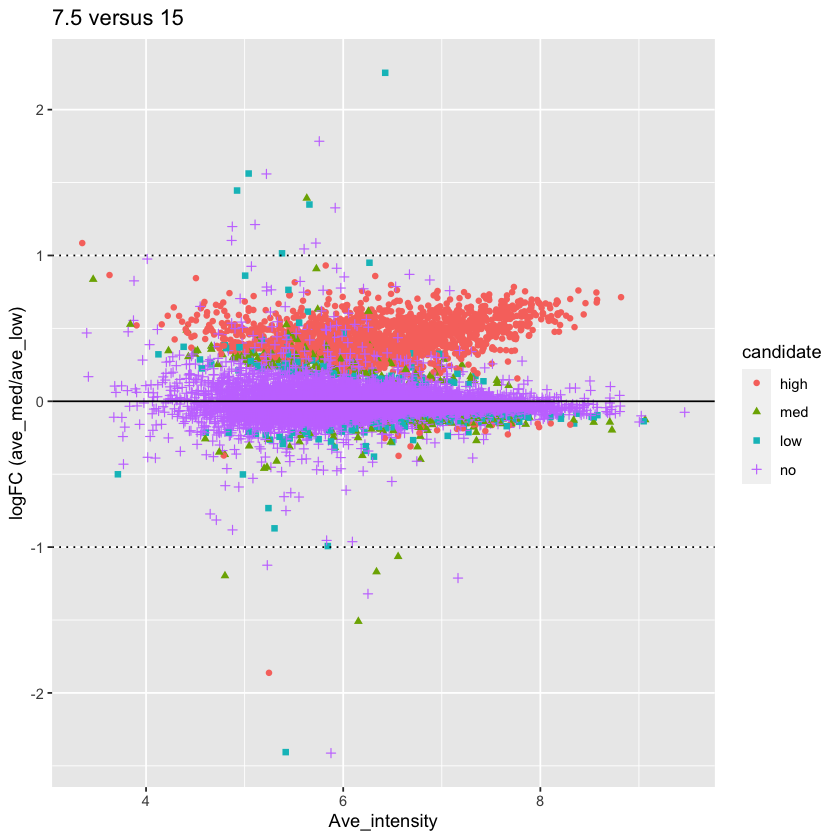

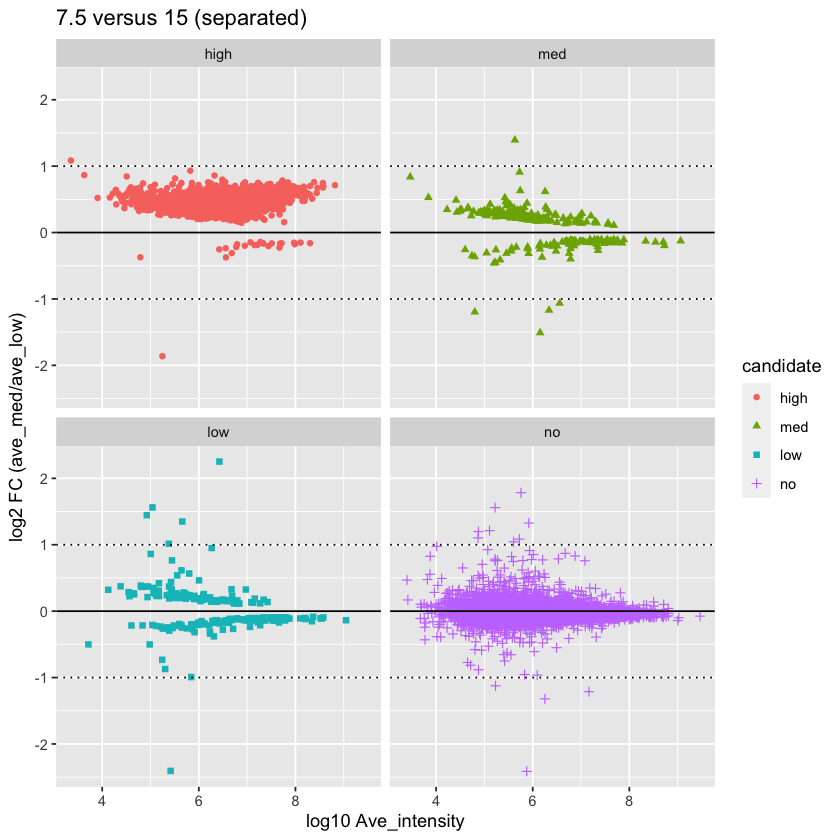

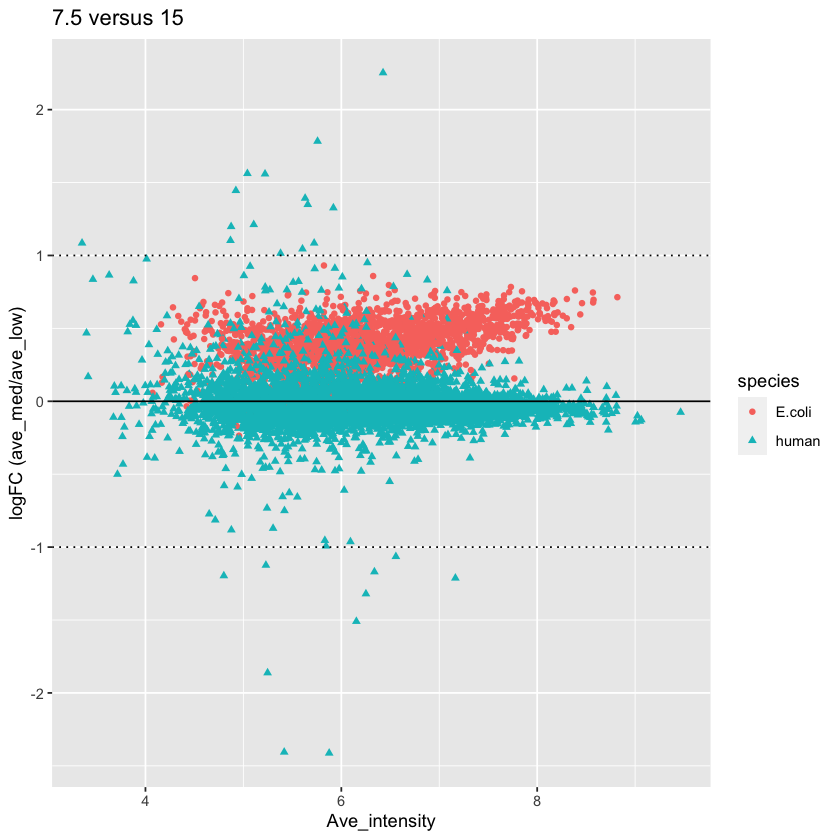

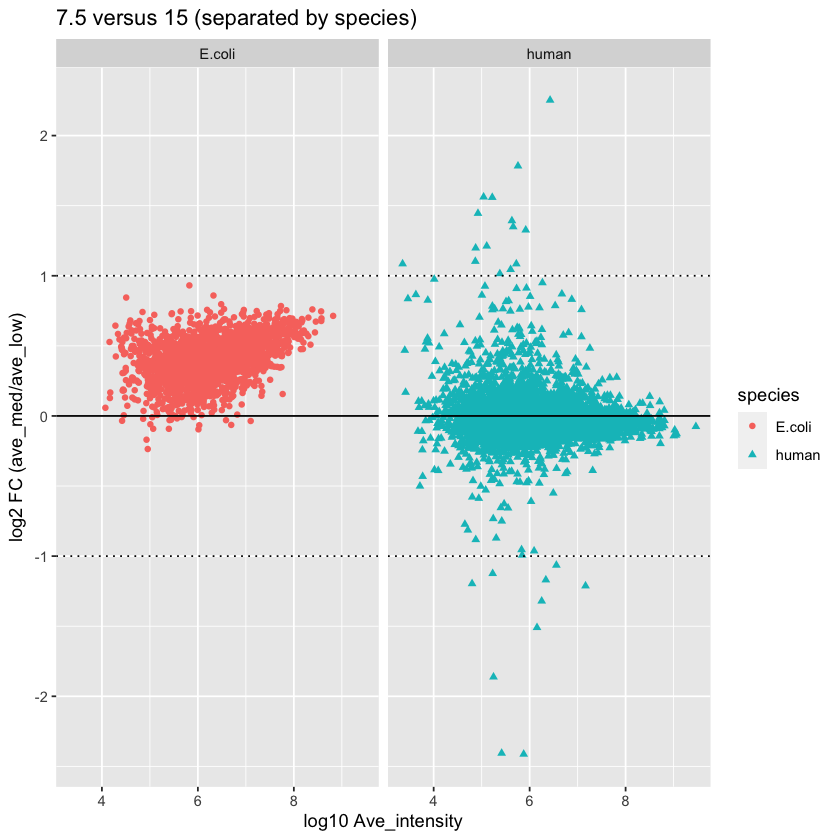

In [10]:
# make MA plots
MA_plots(results, "ave_low", "ave_med", "7.5 versus 15")
MA_species(results, "ave_low", "ave_med", "7.5 versus 15")

### Scatter plots

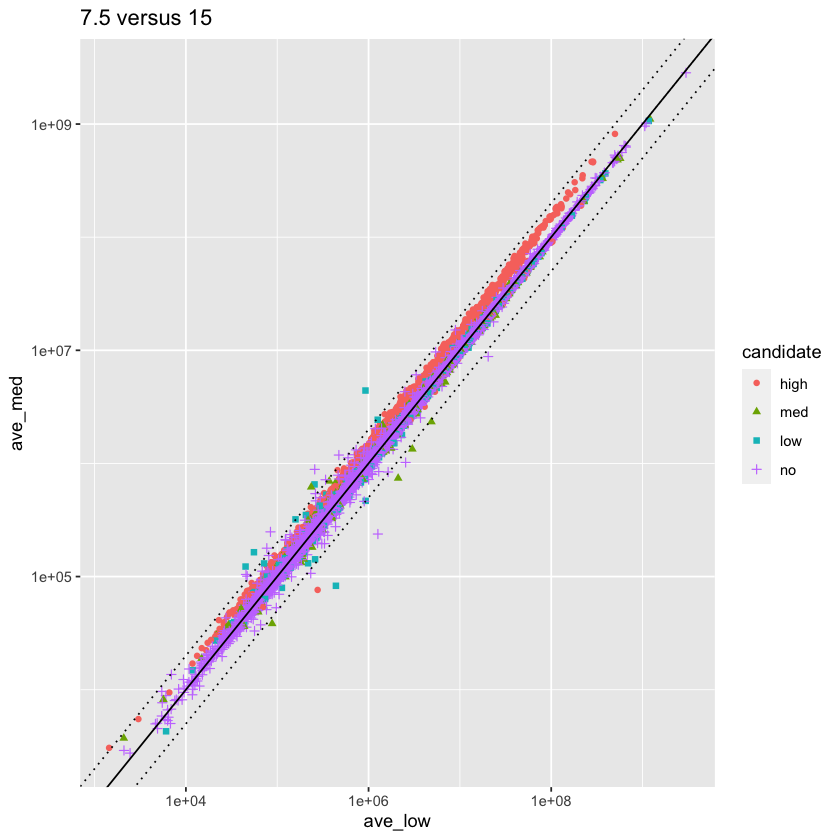

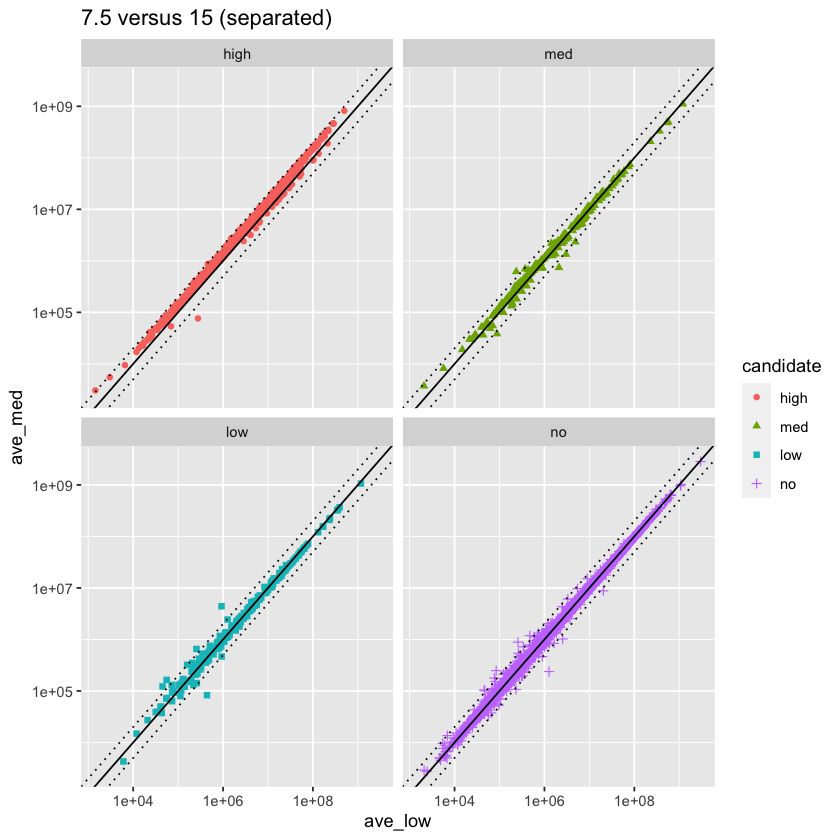

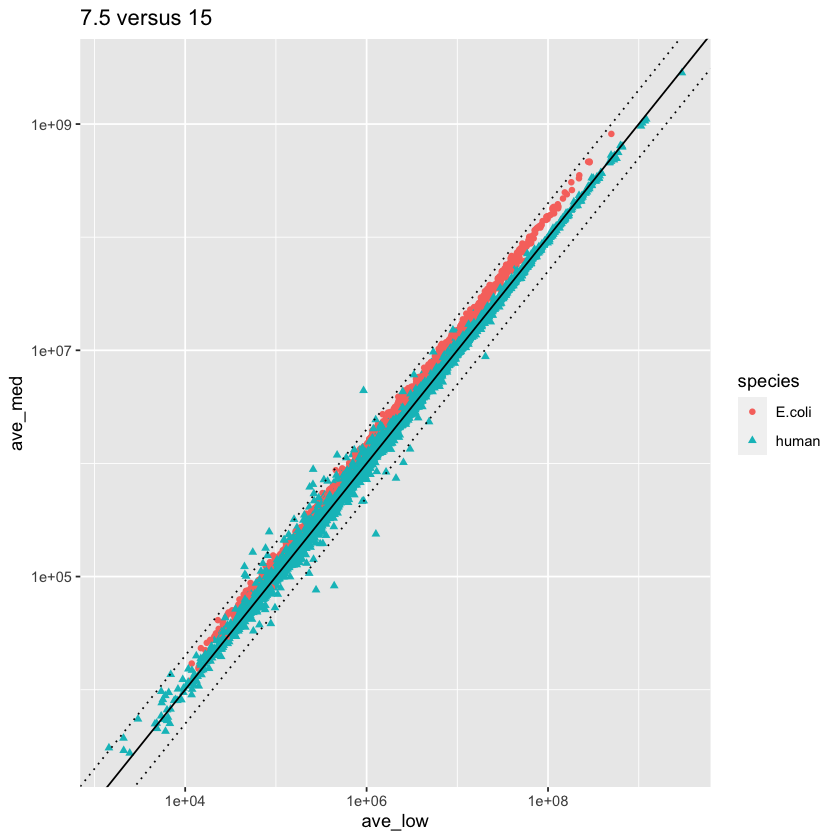

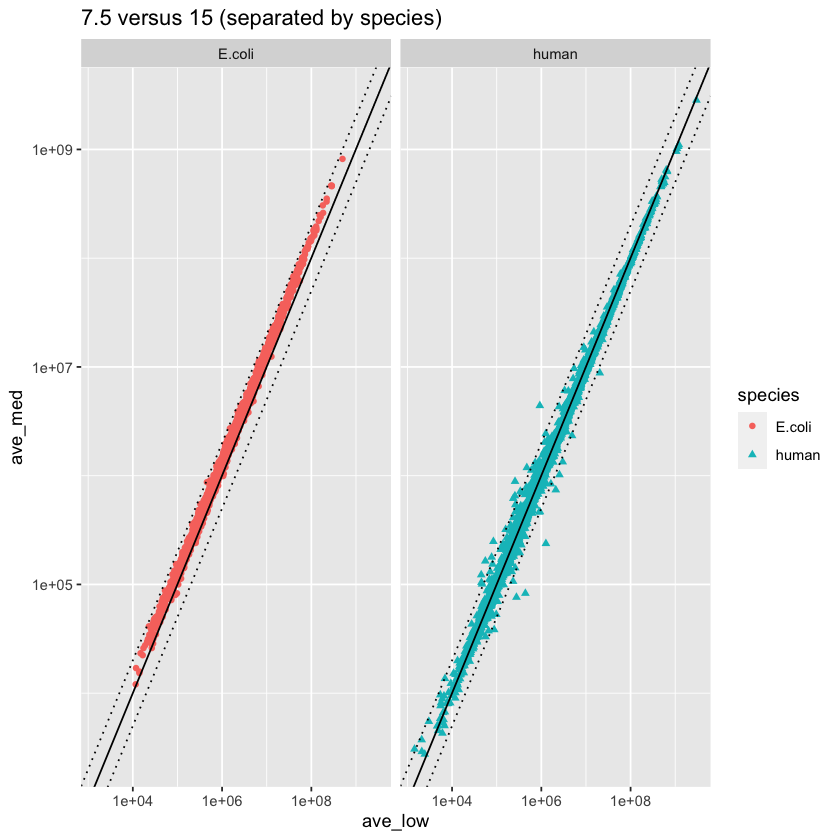

In [11]:
# make scatter plots
scatter_plots(results, "ave_low", "ave_med", "7.5 versus 15")
scatter_species(results, "ave_low", "ave_med", "7.5 versus 15")

### Volcano plot

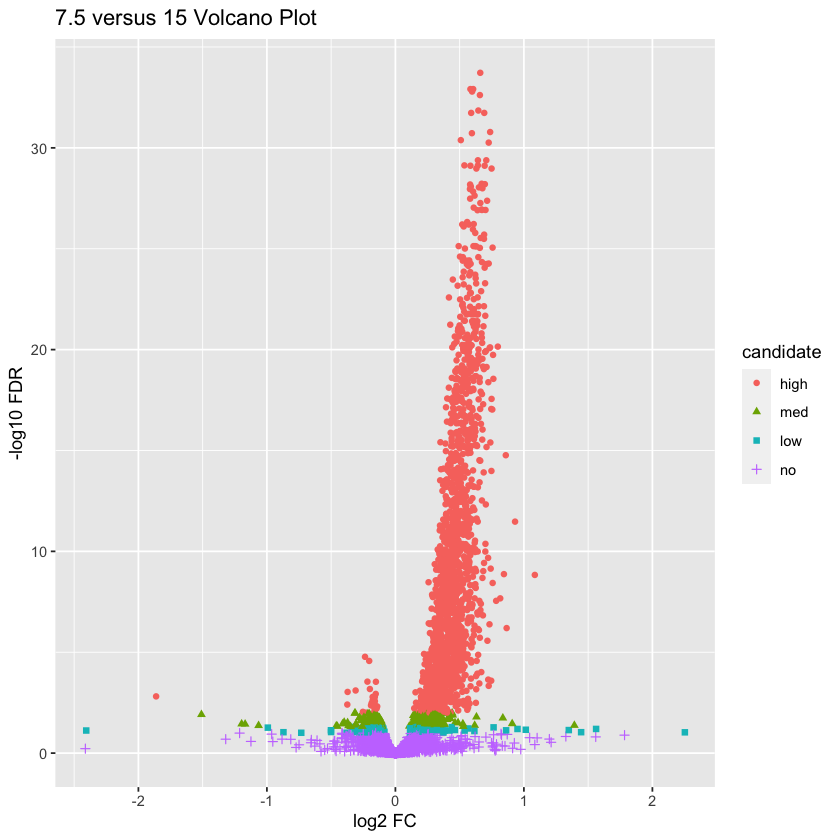

In [12]:
# make a volcano plot
volcano_plot(results, "ave_low", "ave_med", "7.5 versus 15")

### Not all E. coli proteins are DE candidates

We have the E. coli at a supposed 2-fold difference. We have about 10% of the E. coli proteins that are not DE candidates.

### Check some individual protein expression

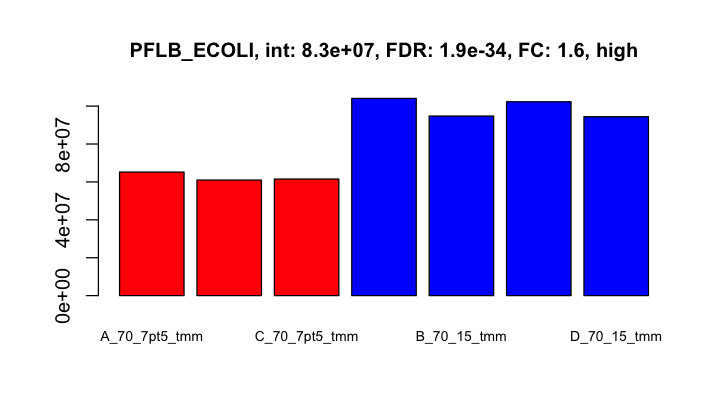

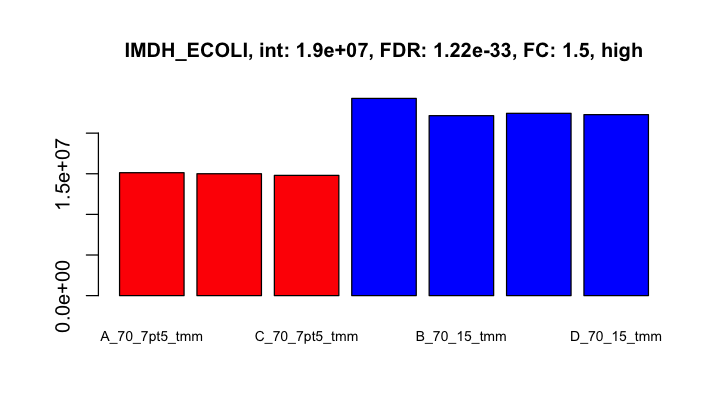

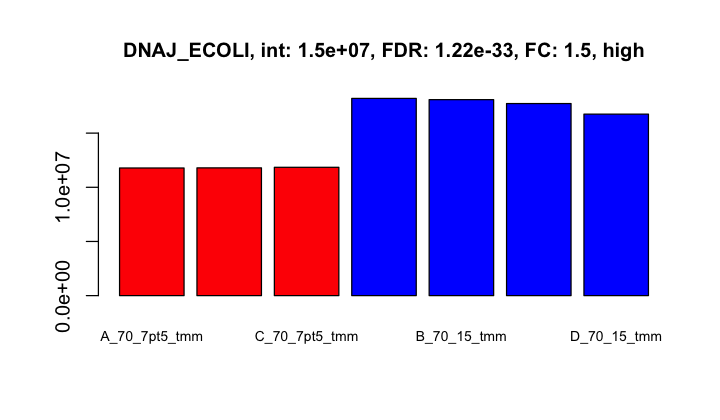

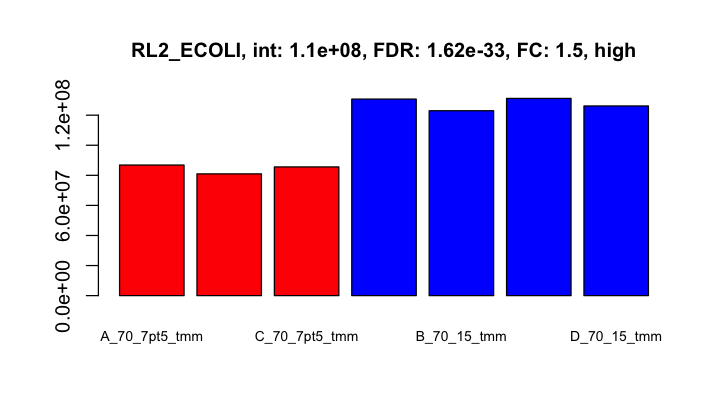

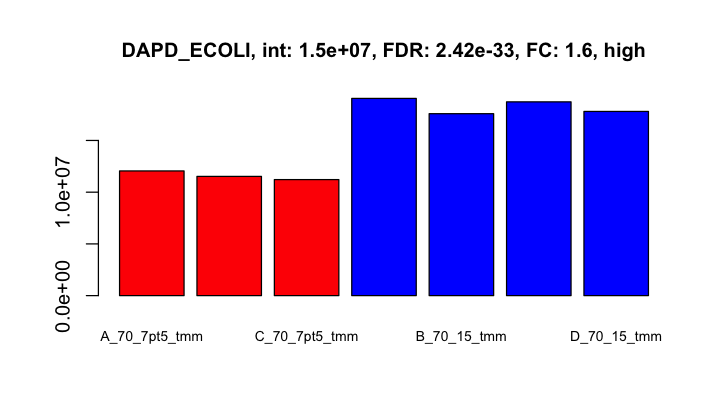

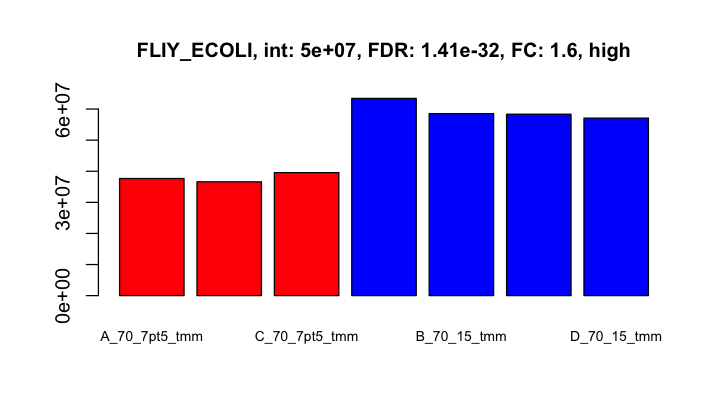

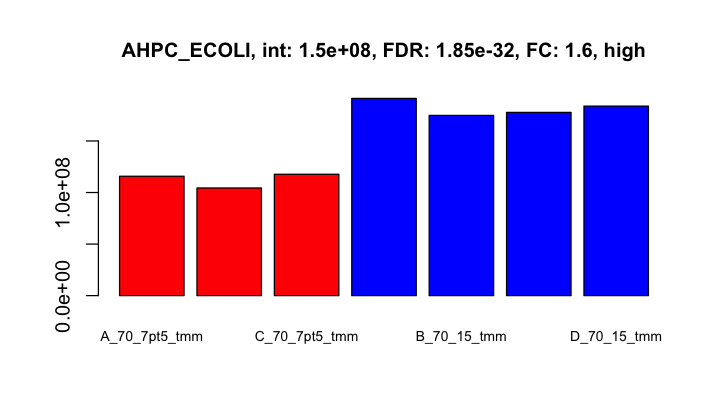

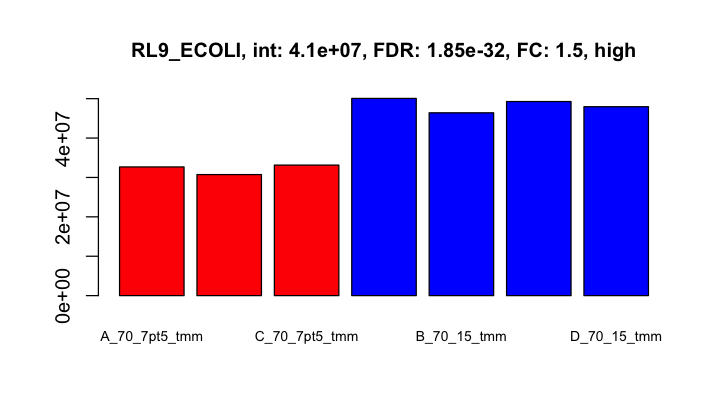

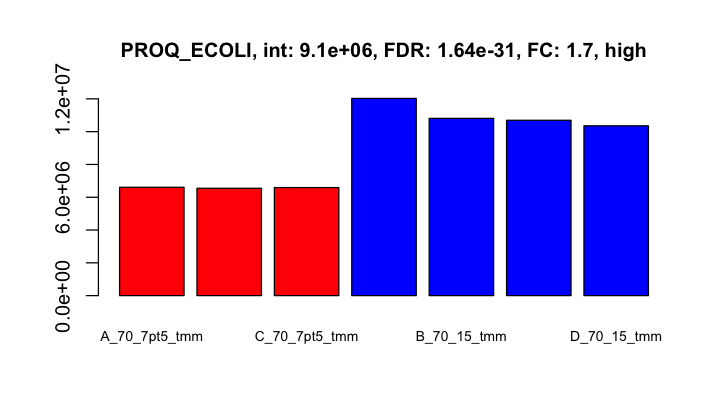

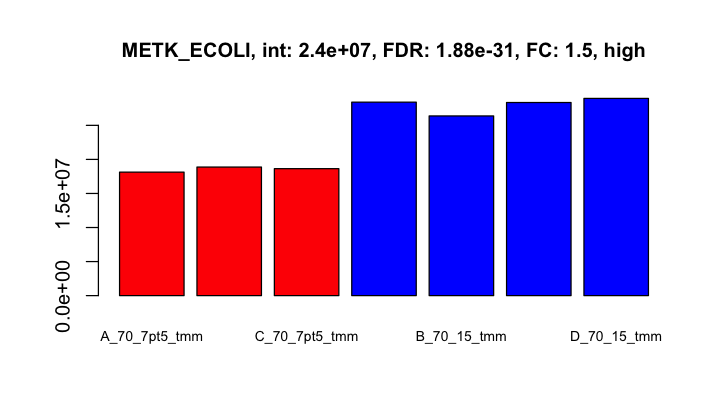

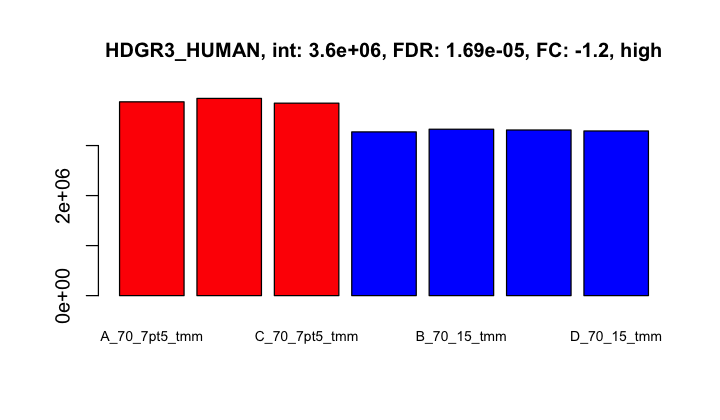

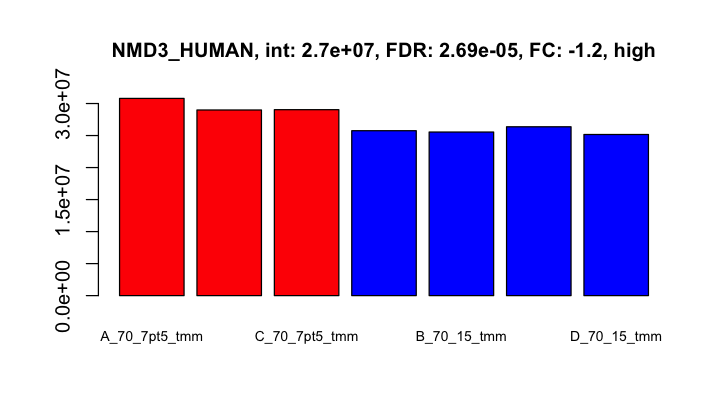

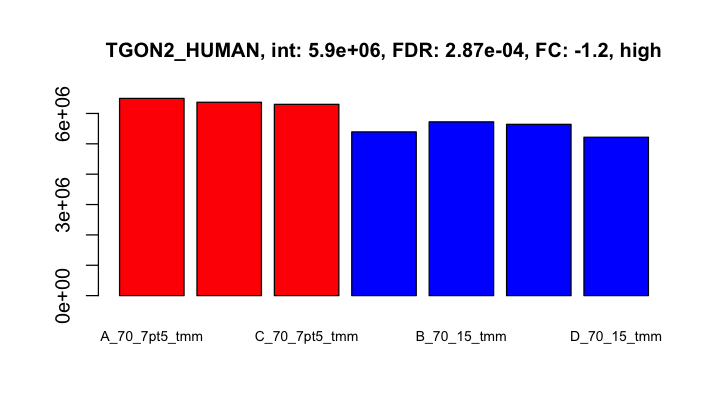

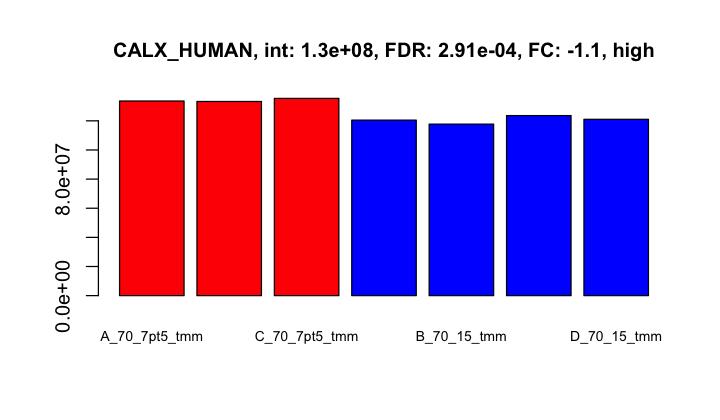

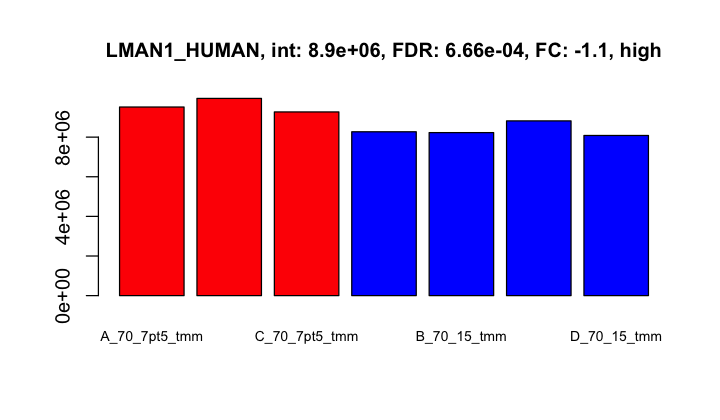

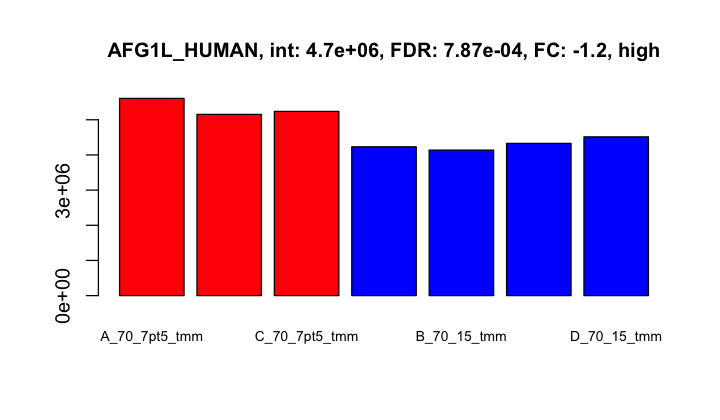

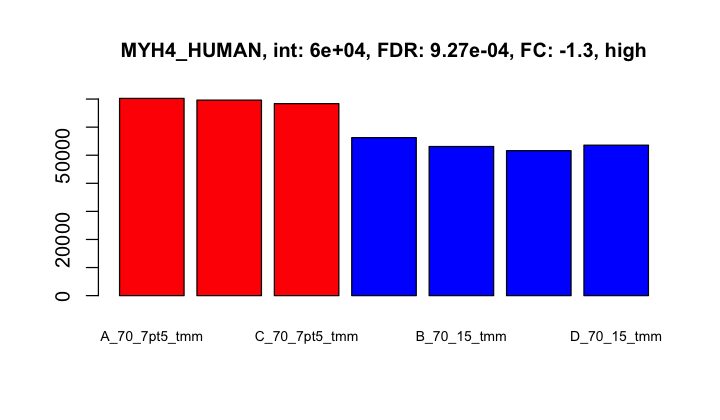

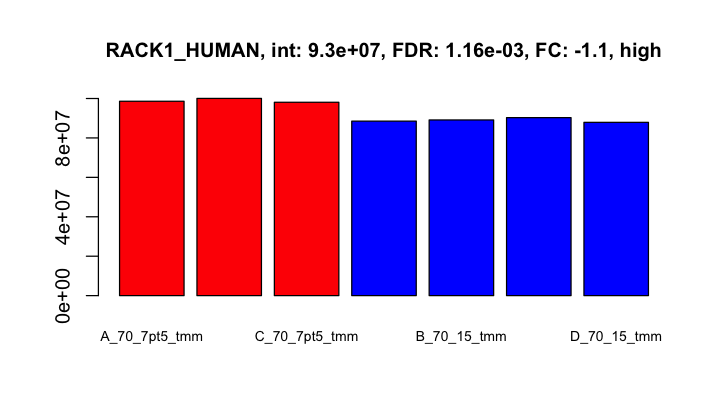

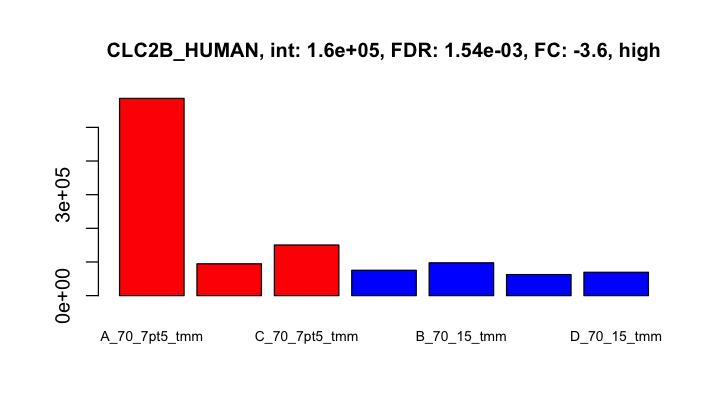

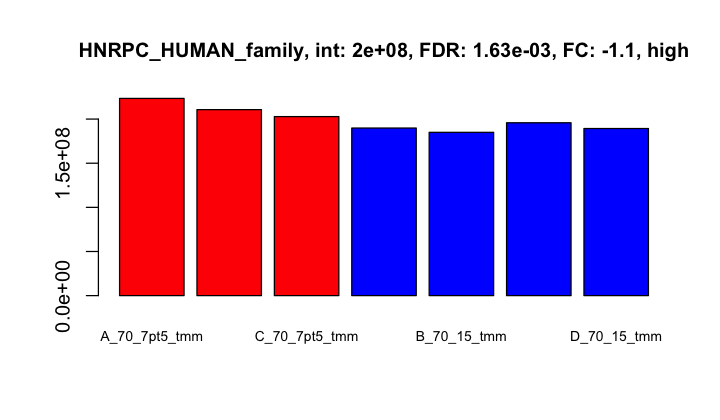

In [13]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 4, 10)
set_plot_dimensions(7, 7)

## <a name="7pt5_45"></a> (2) 7.5 versus 45 microgram E. coli

Compare the 7.5 microgram spike-in level to the 6-fold greater 45 microgram spike-in level.

       high-low
Down       2550
NotSig     4353
Up         2747

genes                logFC    logCPM    PValue        FDR          
1046 sp|P08622|DNAJ_ECOLI 1.593623  7.580124 3.470307e-227 3.348846e-223
381  sp|P0A7R1|RL9_ECOLI  1.618119  9.041035 7.612279e-219 3.672925e-215
538  sp|P63284|CLPB_ECOLI 1.414835  8.601777 6.040437e-216 1.943007e-212
110  sp|P60422|RL2_ECOLI  1.588752 10.420761 1.491820e-214 3.599015e-211
765  sp|P16700|CYSP_ECOLI 1.480988  8.086688 3.947377e-203 7.618438e-200
287  sp|P0AEM9|FLIY_ECOLI 1.691874  9.334523 7.245255e-201 1.165278e-197
158  sp|P09373|PFLB_ECOLI 1.648908 10.039541 3.382295e-197 4.662736e-194
712  sp|P0A953|FABB_ECOLI 1.610030  8.215417 1.858935e-195 2.242340e-192
248  sp|P0A7S9|RS13_ECOLI 1.716630  9.502541 5.222472e-195 5.599651e-192
862  sp|P0ADG7|IMDH_ECOLI 1.524610  7.896581 1.808647e-194 1.745344e-191

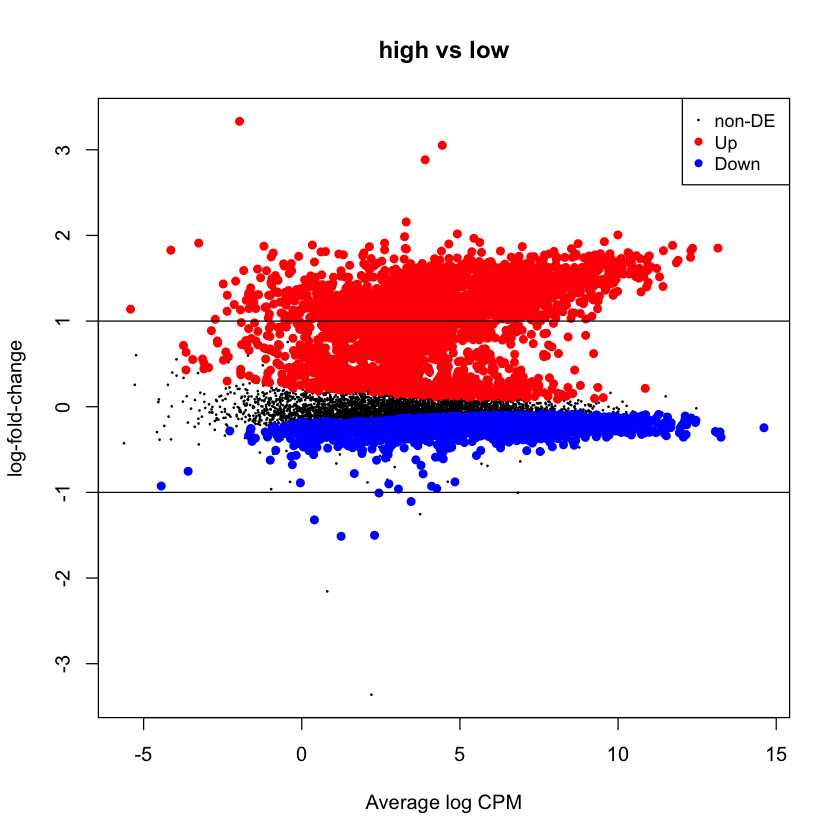

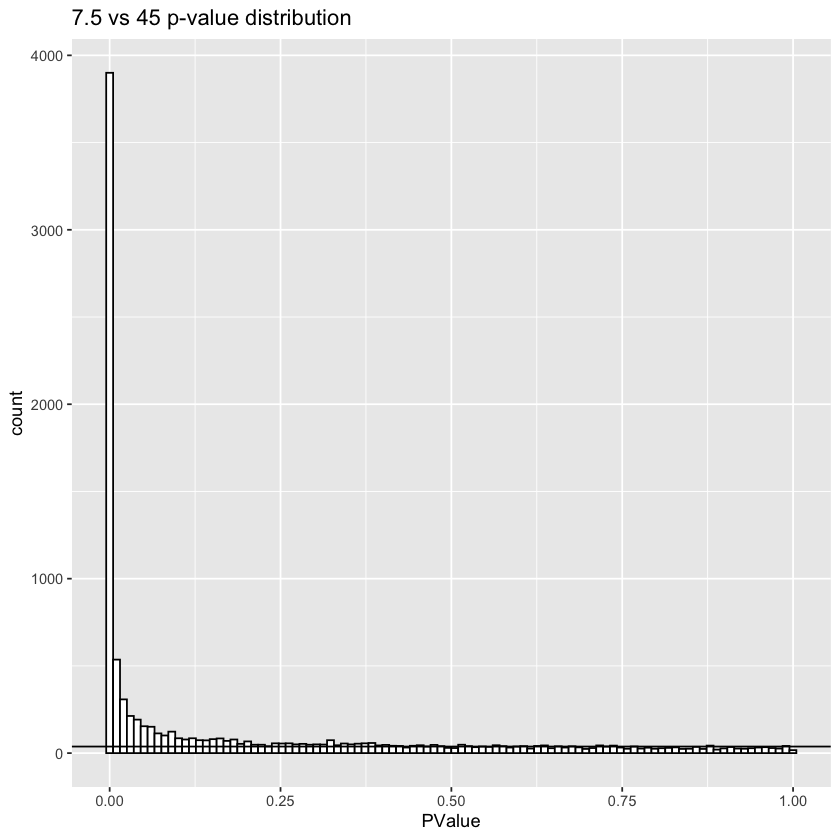

In [14]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("low", "high"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black") # 2-fold change lines

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("7.5 vs 45 p-value distribution")

### We have almost 5,300 candidates!

We have too many candidates. There are only about 2,100 E. coli proteins that were identified. We should have a strong bias towards over-expressed E. coli proteins. Instead, we have a more balanced up and down expression pattern. I would think most of the blue points above should not be DE candidates.


## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

In [15]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, low, "low", high, "high")
results$species <- as.factor(species)

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_low_high")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

[1] "E. coli Summary"


candidate n   
1 high      2054
2 med         16
3 low          3
4 no          18

[1] "Human Summary"


candidate n   
1 high      1743
2 med        916
3 low        565
4 no        4335

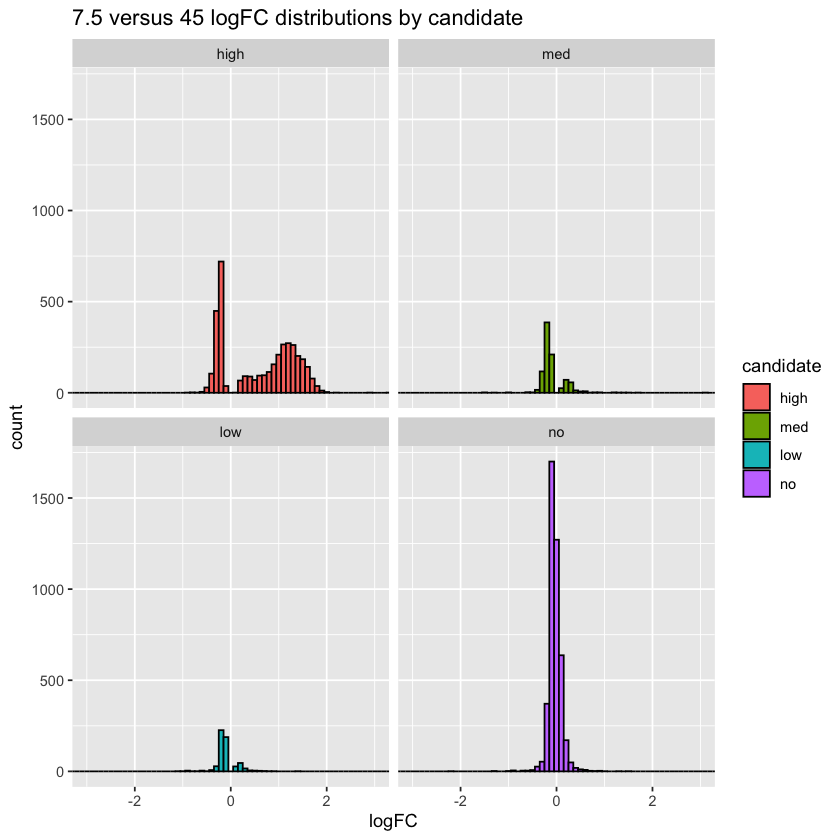

In [16]:
# see how many candidates by category
print("E. coli Summary")
results %>% filter(species == "E.coli") %>% count(candidate)

print("Human Summary")
results %>% filter(species == "human") %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("7.5 versus 45 logFC distributions by candidate")

### Too many human DE candidates

We have 3,224 of the constant human background proteins that are DE candidates.

### MA plots

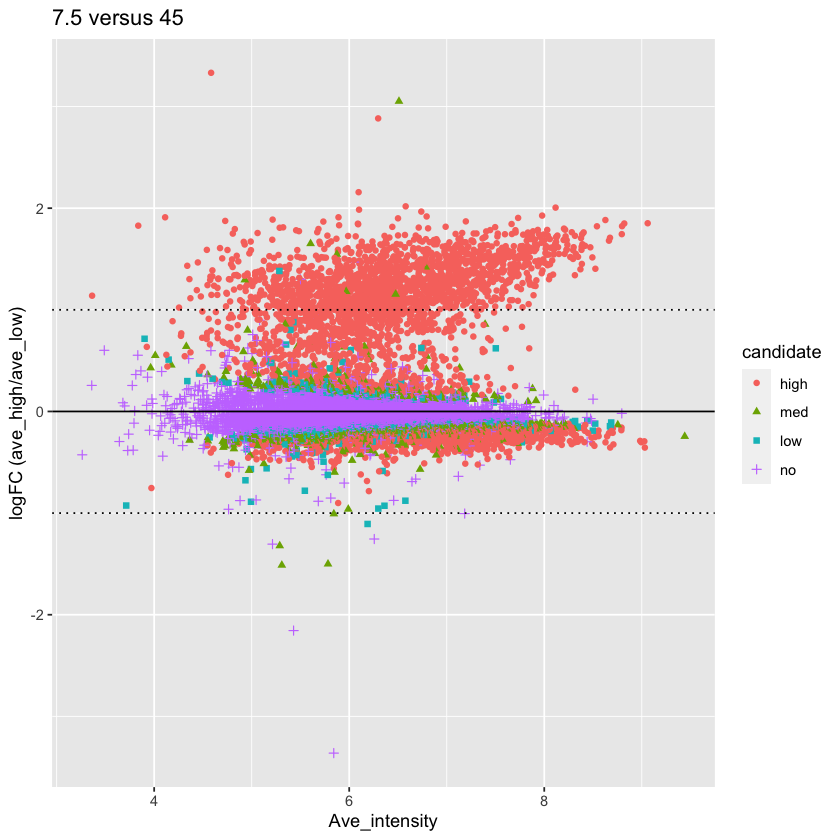

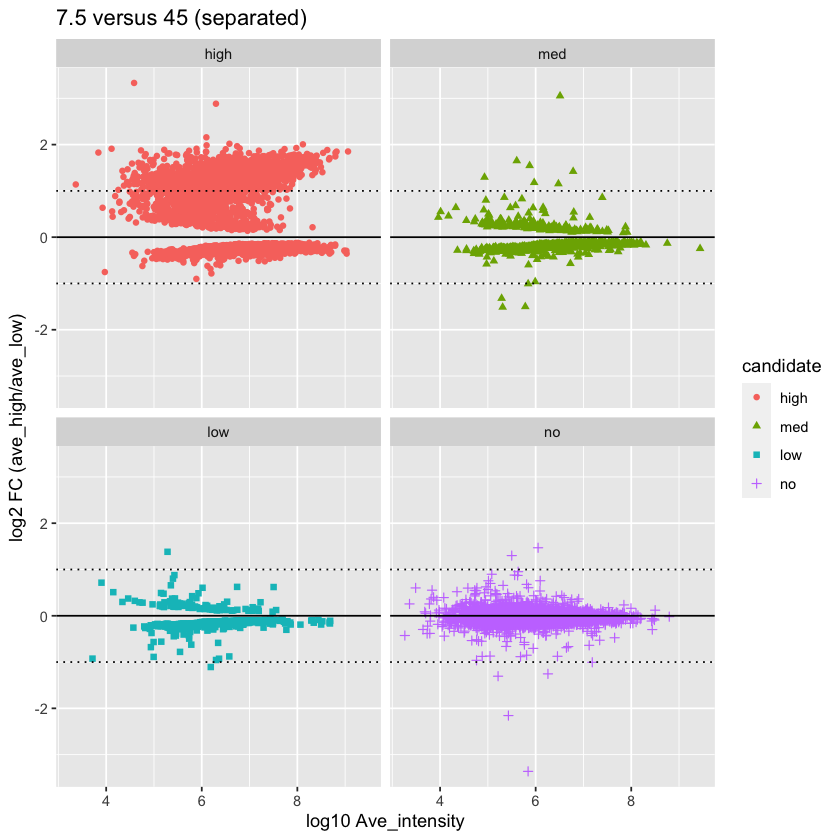

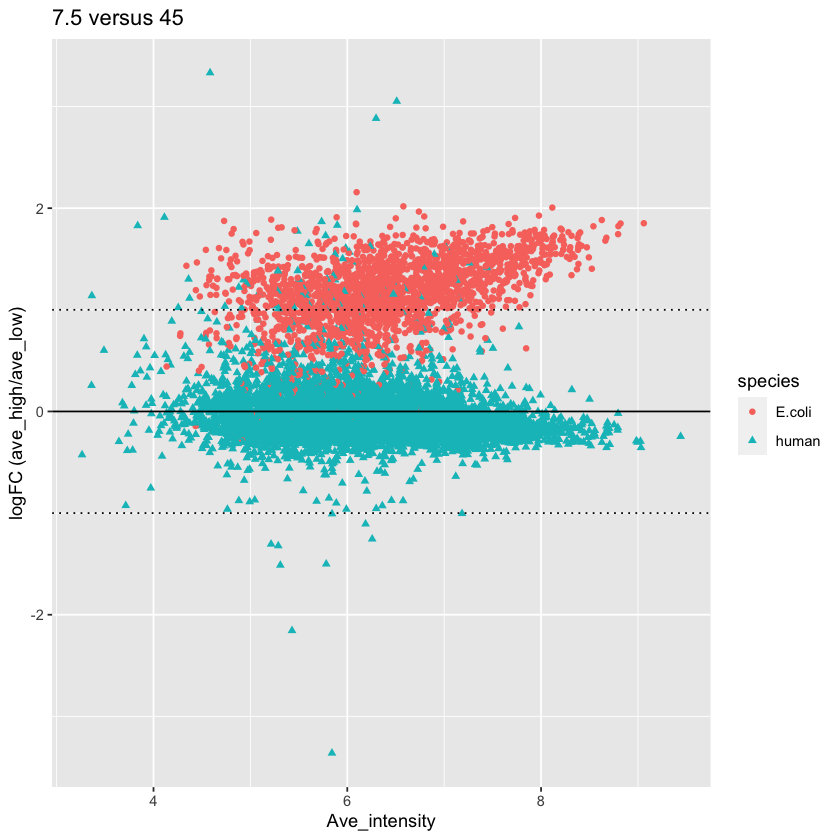

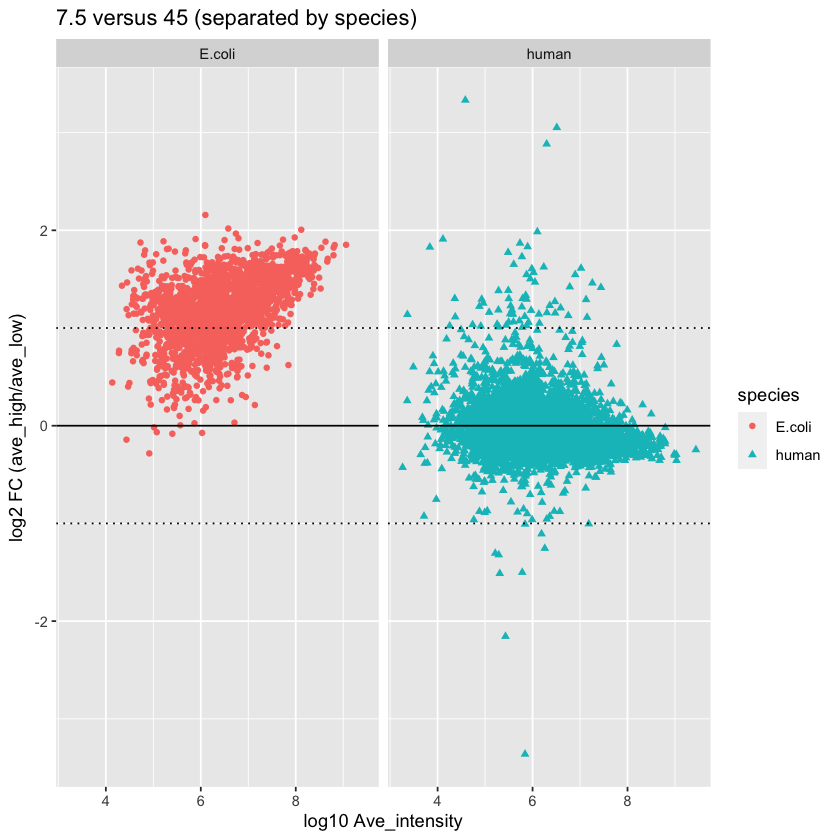

In [17]:
# make MA plots
MA_plots(results, "ave_low", "ave_high", "7.5 versus 45")
MA_species(results, "ave_low", "ave_high", "7.5 versus 45")

### Scatter plots

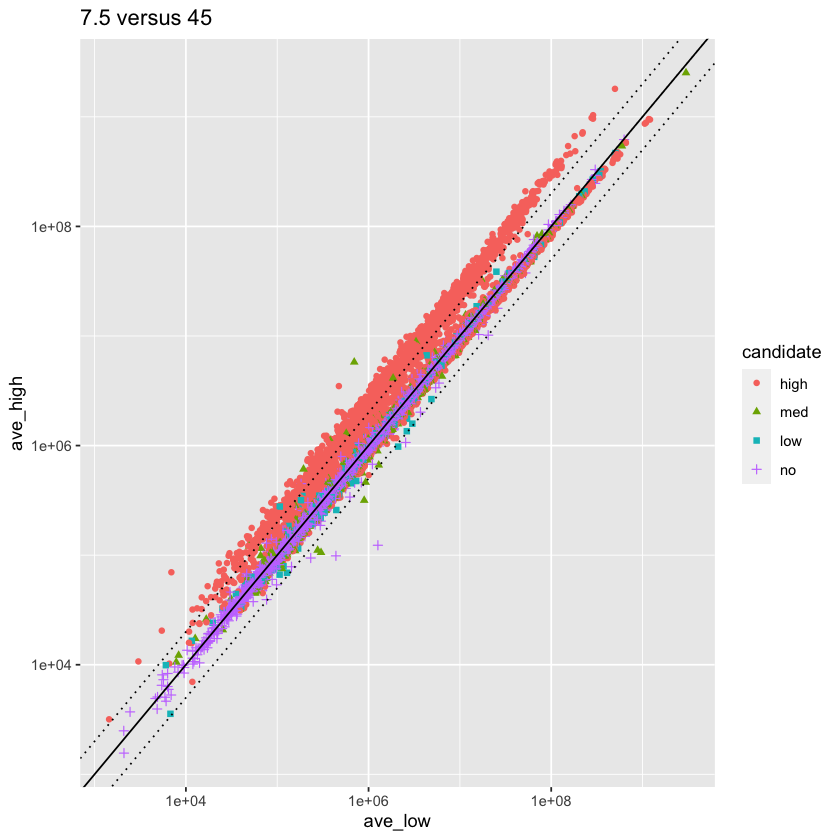

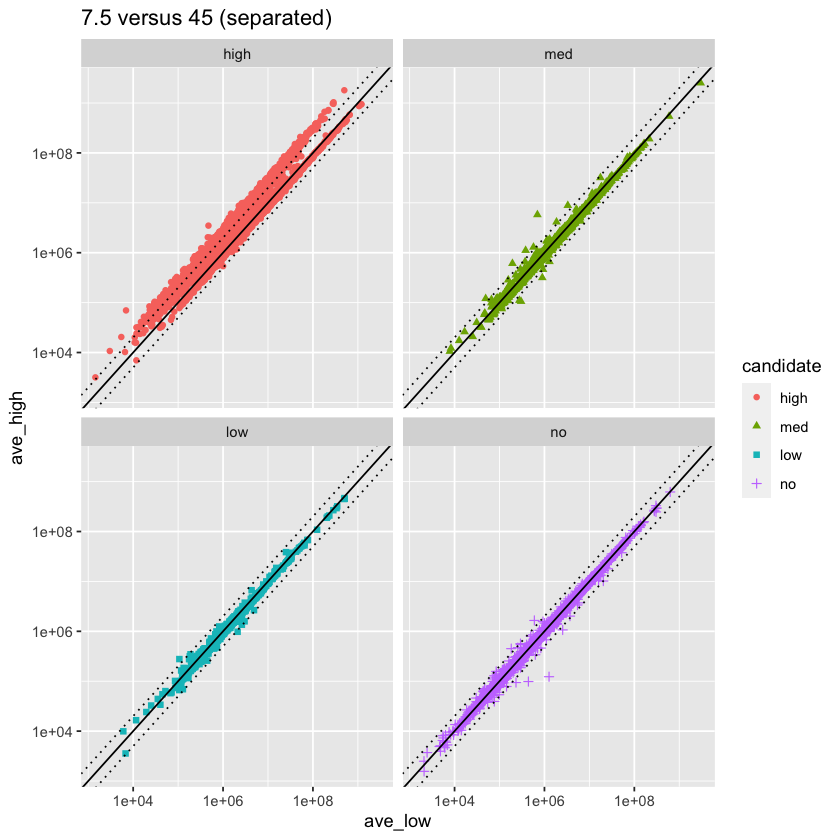

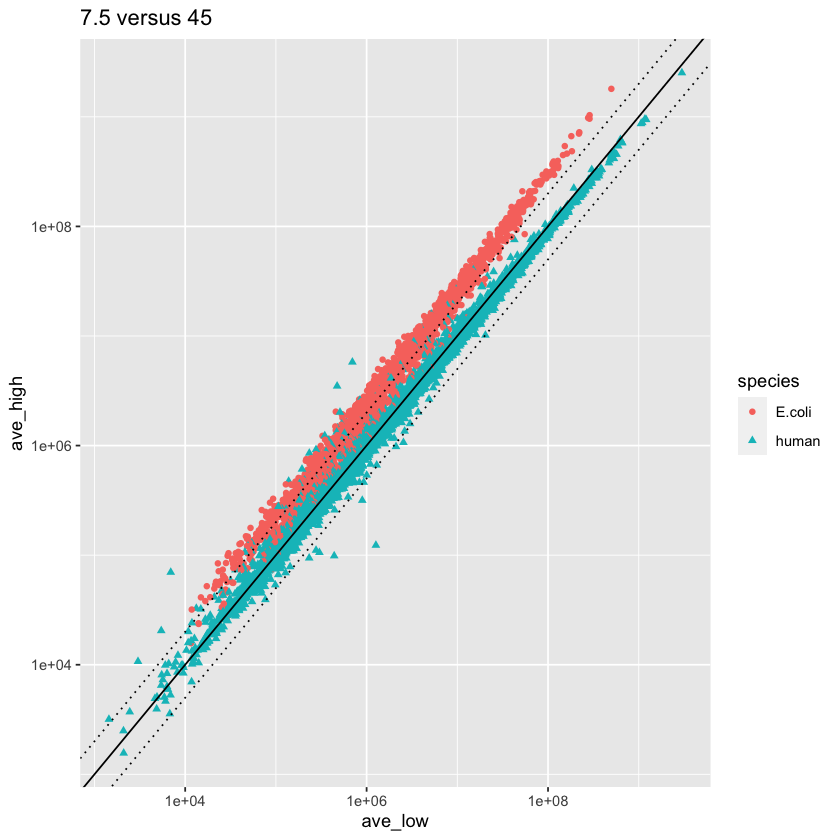

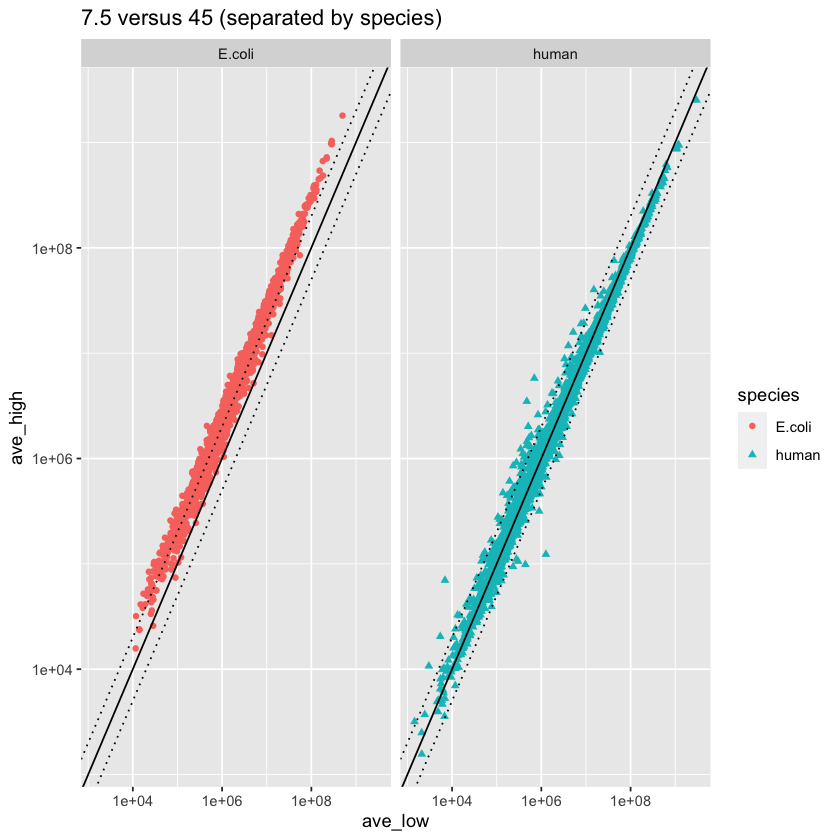

In [18]:
# make scatter plots
scatter_plots(results,  "ave_low", "ave_high", "7.5 versus 45")
scatter_species(results,  "ave_low", "ave_high", "7.5 versus 45")

### Volcano plot

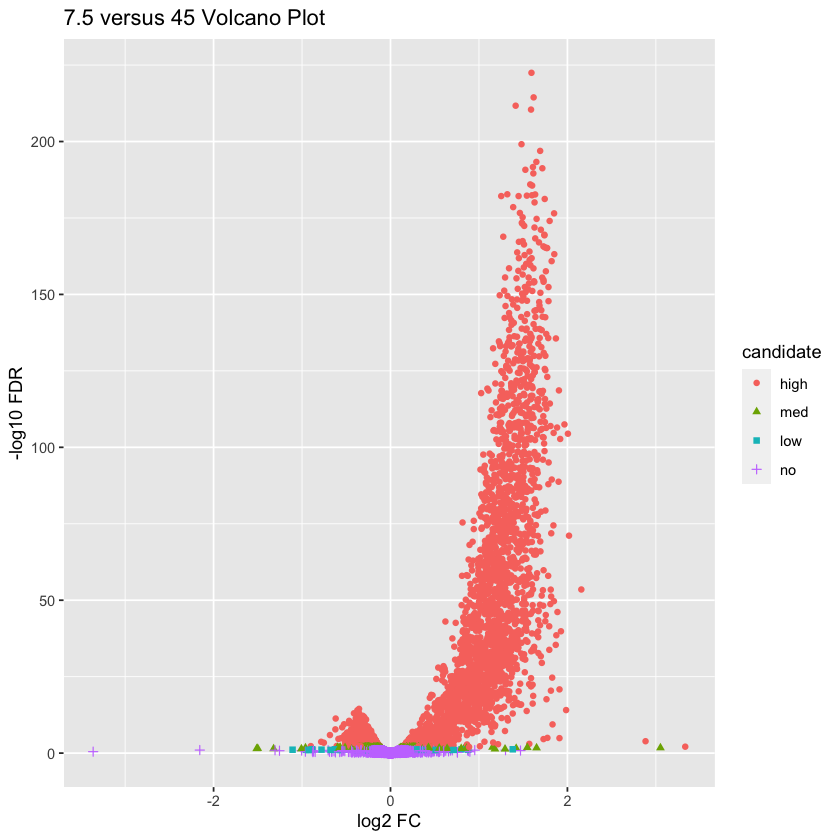

In [19]:
# make a volcano plot
volcano_plot(results,  "ave_low", "ave_high", "7.5 versus 45")

### Many E. coli candidates have fold-changes greater than 2-fold (6-fold is expected)

We have most E. coli proteins being DE candidates in this 6-fold spike-in difference. We have many E. coli with more than 2-fold (none more than about 3-fold, though), but also many with less than 2-fold changes.

### Check some individual protein expression

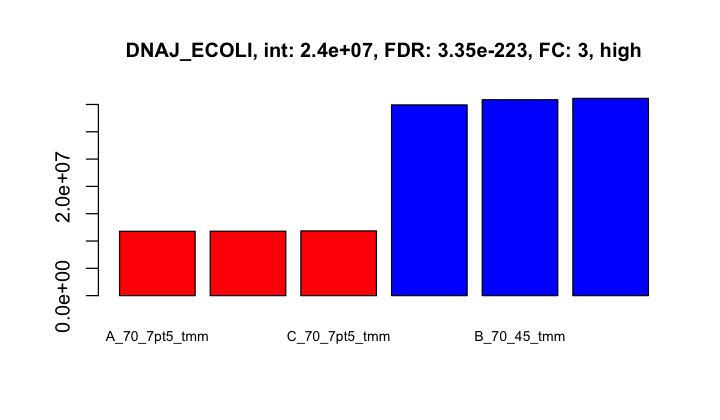

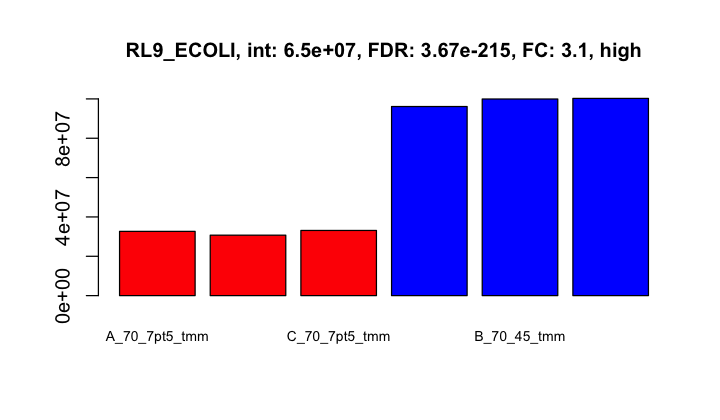

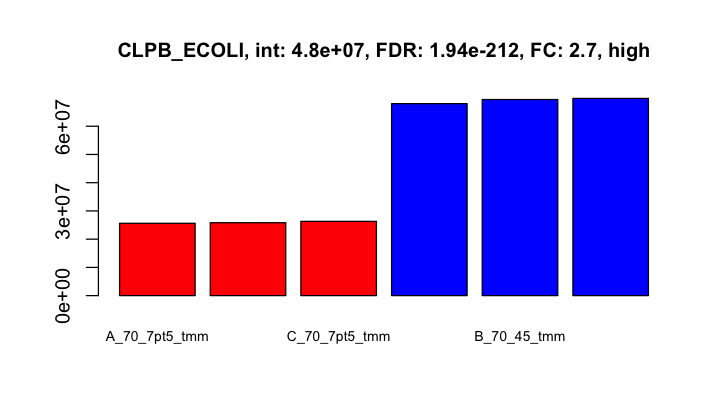

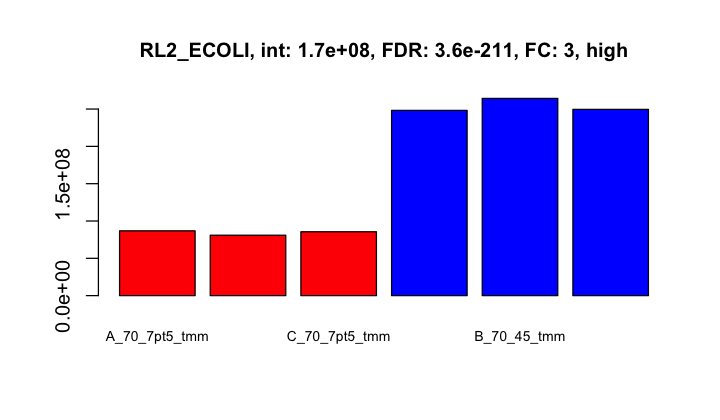

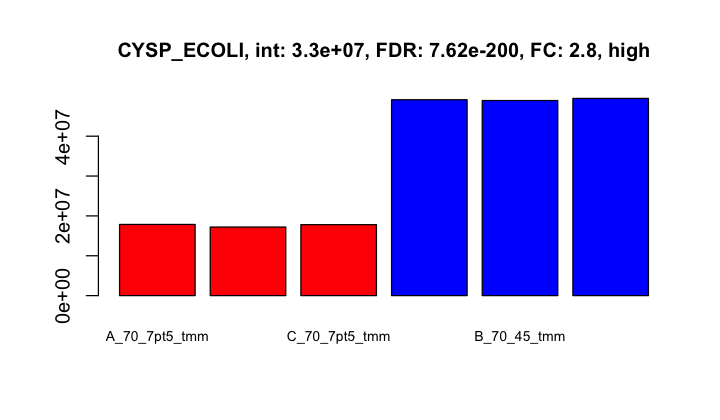

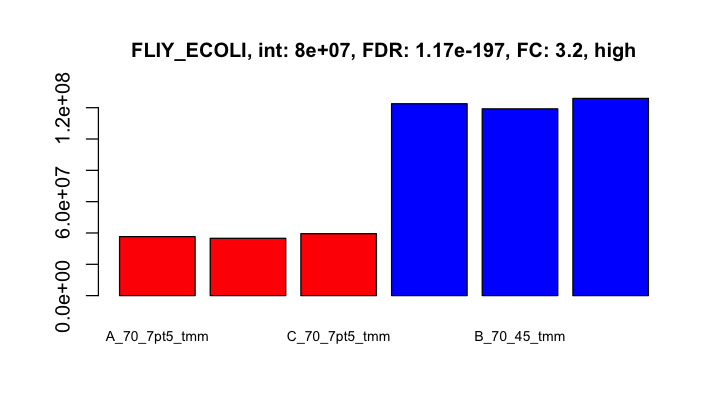

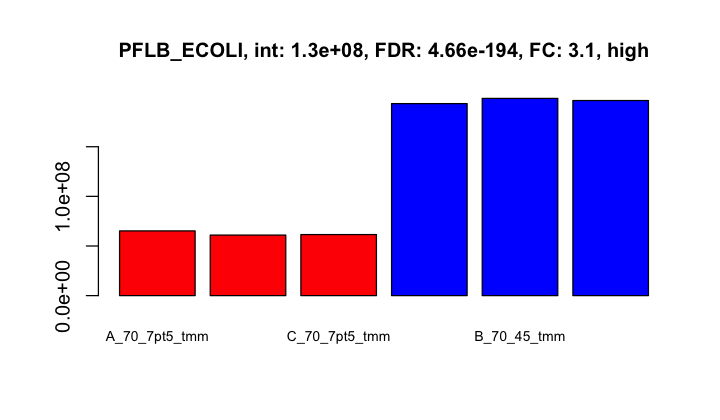

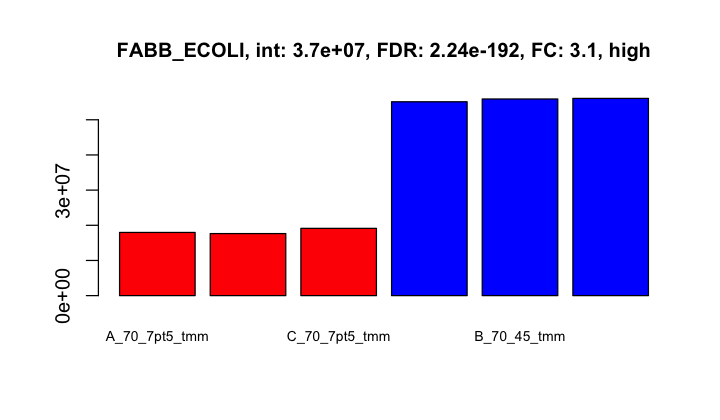

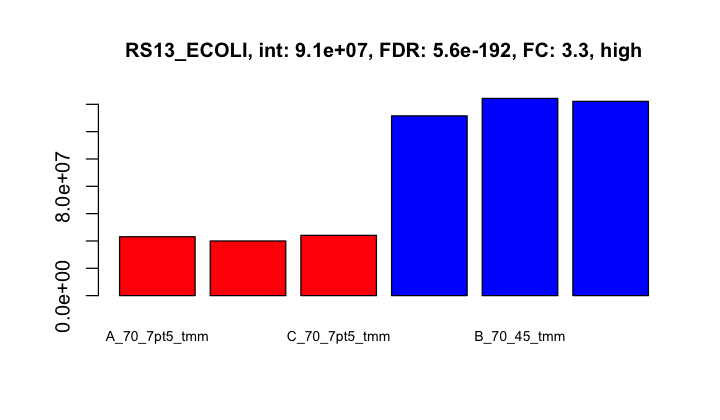

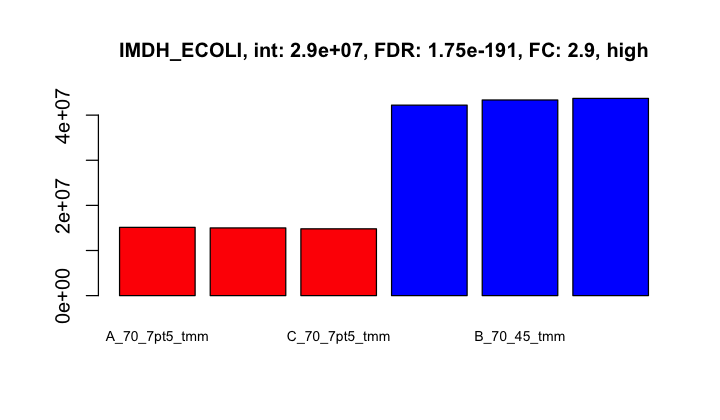

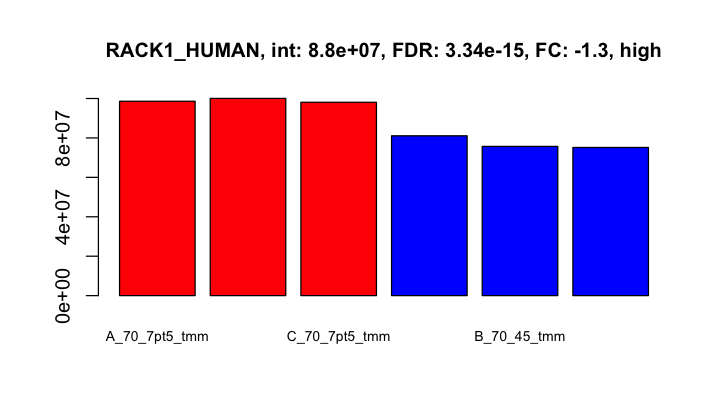

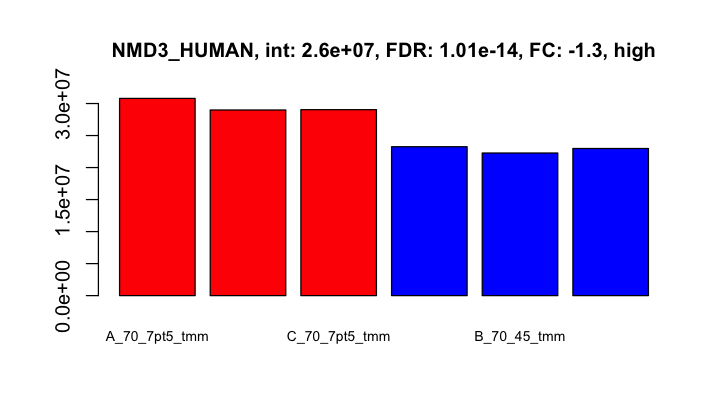

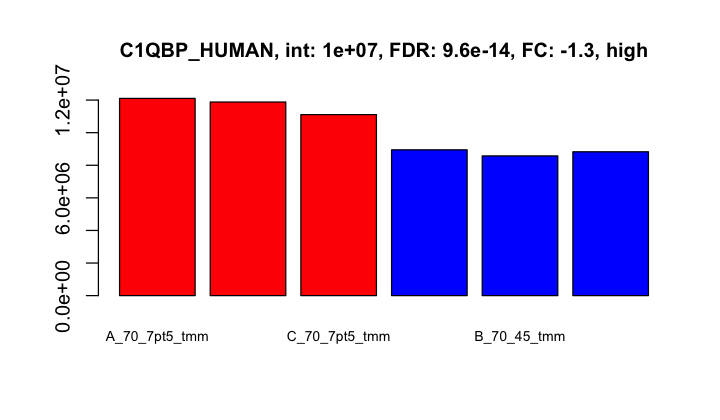

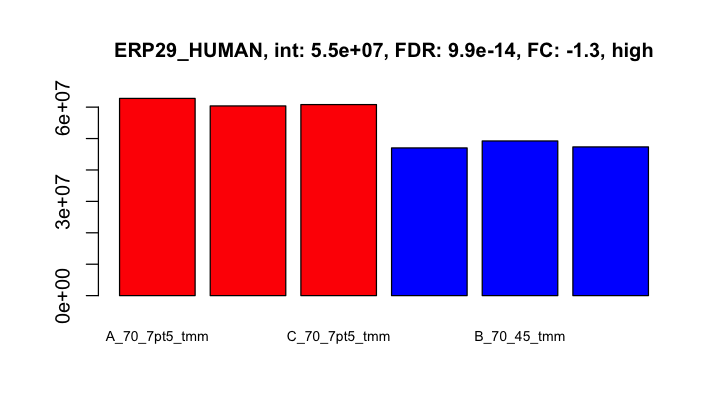

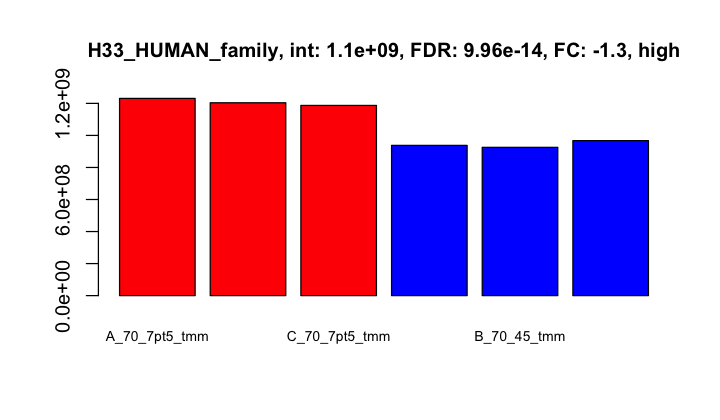

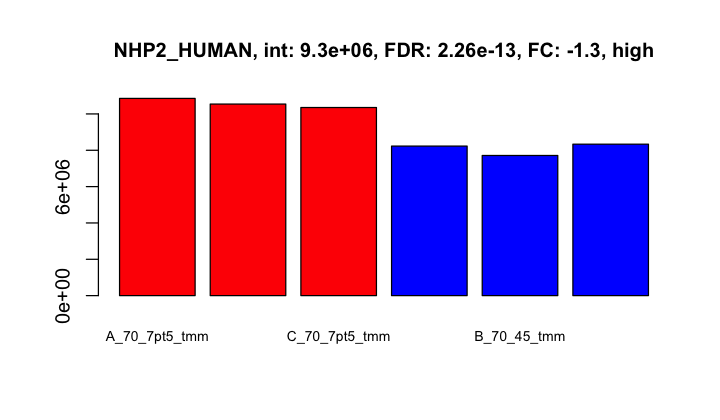

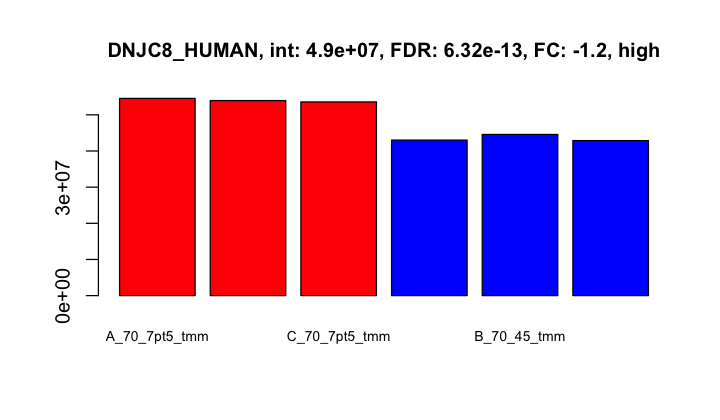

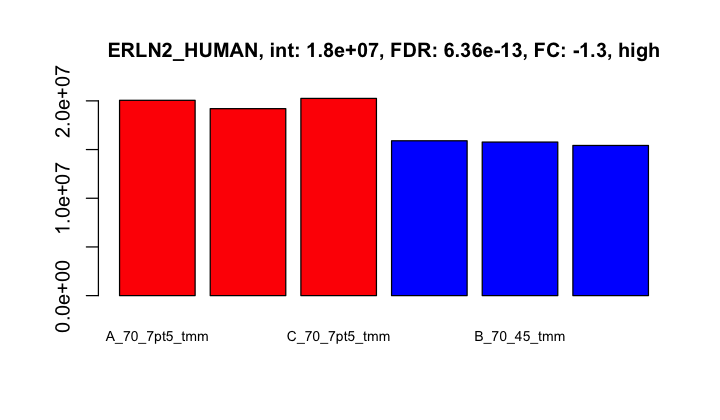

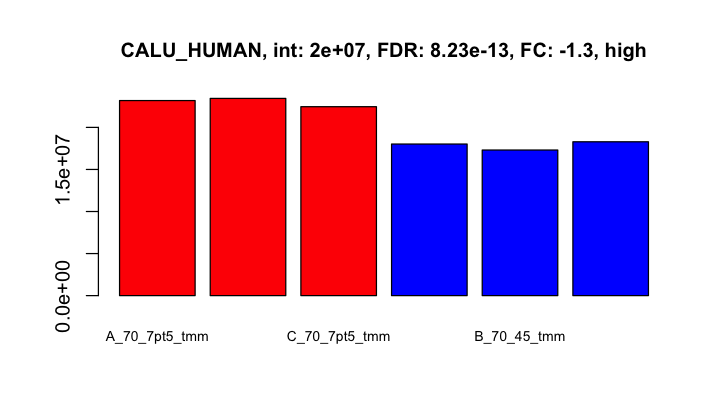

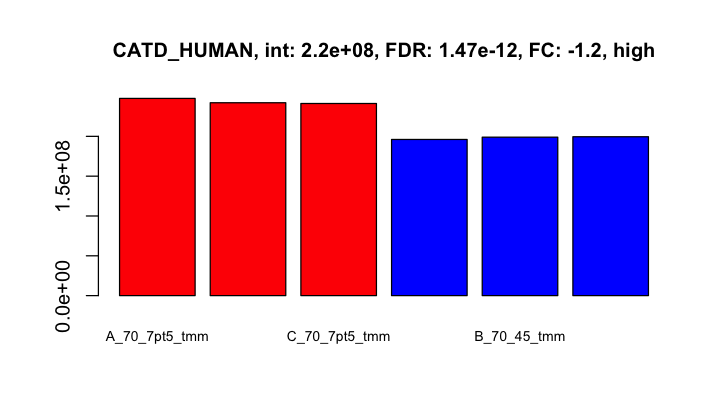

In [20]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 3, 3, 10)
set_plot_dimensions(7, 7)

### E. coli fold-changes seem to max out at 3-fold

The increase in E. coli expression is easy to believe from the up-regulated proteins. However, the largest fold changes seem to be about 3-fold instead of the expected 6-fold. All of the down-regulated proteins are human and have pretty small fold-changes.

----

## <a name="15_45"></a> (3) 15 versus 45 microgram E. coli

Compare the 15 microgram E. coli level to the 45 microgram level.

       high-med
Down       1644
NotSig     5419
Up         2587

genes                logFC     logCPM    PValue        FDR          
1046 sp|P08622|DNAJ_ECOLI 1.0098828  7.580124 6.475204e-112 6.248571e-108
381  sp|P0A7R1|RL9_ECOLI  1.0284262  9.041035 1.333093e-108 6.432172e-105
538  sp|P63284|CLPB_ECOLI 0.9057177  8.601777 1.406841e-107 4.525340e-104
110  sp|P60422|RL2_ECOLI  0.9919036 10.420761 1.112873e-102  2.684807e-99
765  sp|P16700|CYSP_ECOLI 0.9440315  8.086688 9.729277e-101  1.877751e-97
929  sp|P0ADS6|YGGE_ECOLI 0.8351875  7.768022  1.253559e-99  2.016140e-96
546  sp|P0AG44|RL17_ECOLI 0.8736959  8.590510  1.119589e-98  1.543433e-95
712  sp|P0A953|FABB_ECOLI 1.0298691  8.215417  2.816950e-98  3.397946e-95
1775 sp|P75818|YBJP_ECOLI 1.0022693  6.587487  3.464198e-97  3.714390e-94
248  sp|P0A7S9|RS13_ECOLI 1.0865543  9.502541  1.336011e-96  1.289251e-93

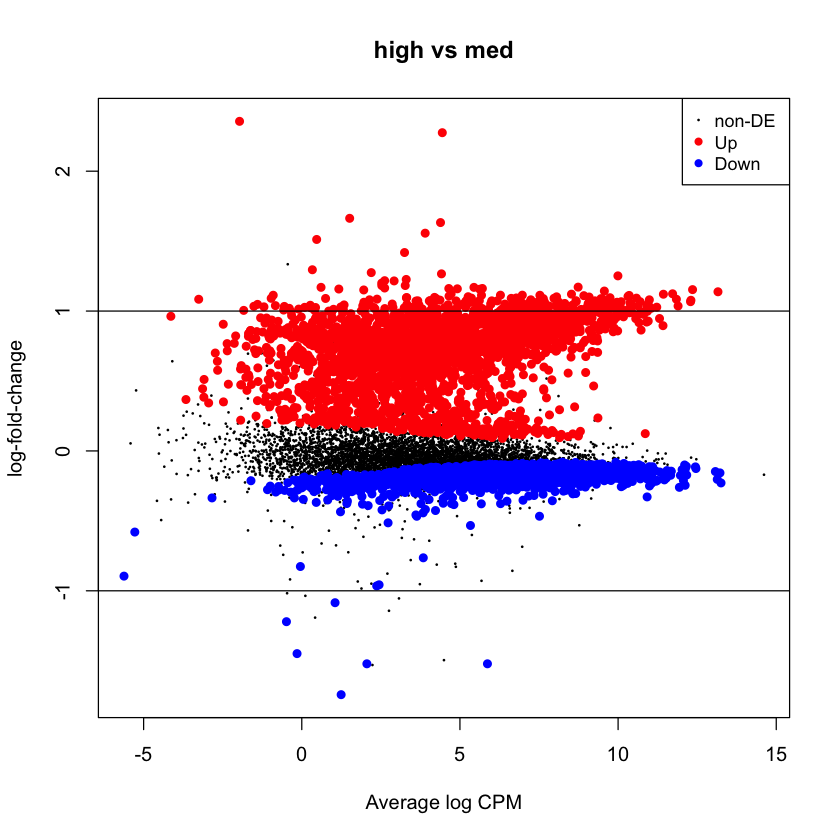

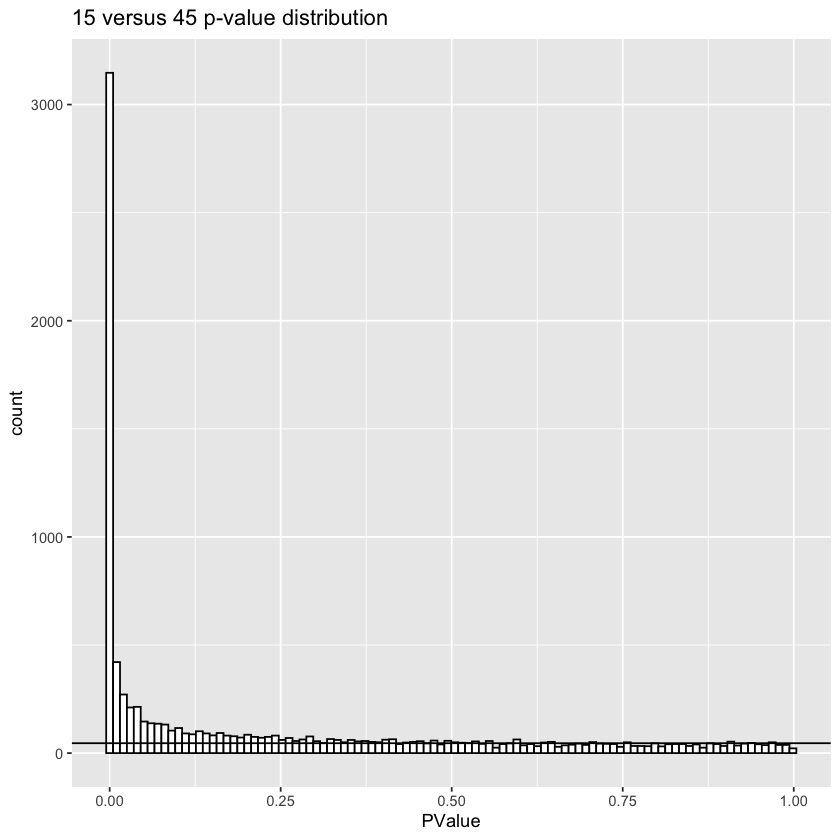

In [21]:
# the exact test object has columns like fold-change, CPM, and p-values
et <- exactTest(y, pair = c("med", "high"))

# this counts up, down, and unchanged genes (proteins) at 10% FDR
summary(decideTestsDGE(et, p.value = 0.10))

# the topTags function adds the BH FDR values to an exactTest data frame 
# make sure we do not change the row order (the sort.by parameter)!
topTags(et)$table
tt <- topTags(et, n = Inf, sort.by = "none")

# make an MD plot (like MA plot)
plotMD(et, p.value = 0.10)
abline(h = c(-1, 1), col = "black")

# check the p-value distribution
ggplot(tt$table, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("15 versus 45 p-value distribution")

### We have a similar DE candidate situation

The over-expressed E. coli proteins are mostly DE candidates, as expected. We have about 2,000 extra DE candidates over the 2,100 or so E. coli proteins. We have many human proteins that are significantly down regulated and that does not seem right.

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

Even though we have few candidates, we will still make the MA plot, scatter plot, and volcano plot.

In [22]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, med, "med", high, "high")
results$species <- as.factor(species)

# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_med_high")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

[1] "E. coli Summary"


candidate n   
1 high      2036
2 med         19
3 low          7
4 no          29

[1] "Human Summary"


candidate n   
1 high       950
2 med        672
3 low        547
4 no        5390

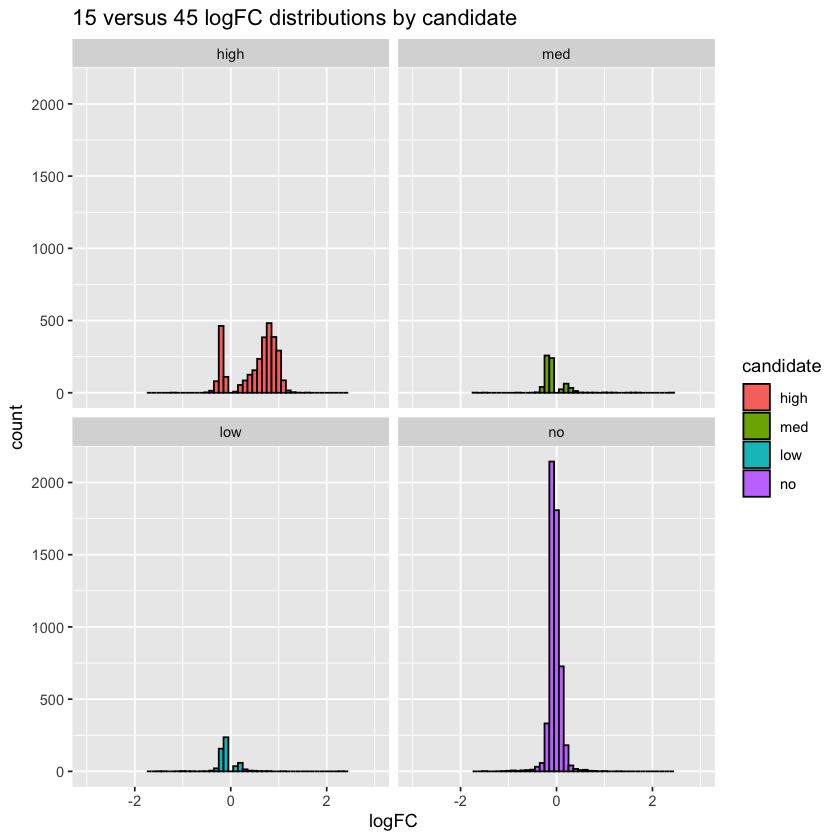

In [23]:
# see how many candidates by category
print("E. coli Summary")
results %>% filter(species == "E.coli") %>% count(candidate)

print("Human Summary")
results %>% filter(species == "human") %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-3, 3)) +
  ggtitle("15 versus 45 logFC distributions by candidate")

### There are over 2100 human DE candidates

### MA plots

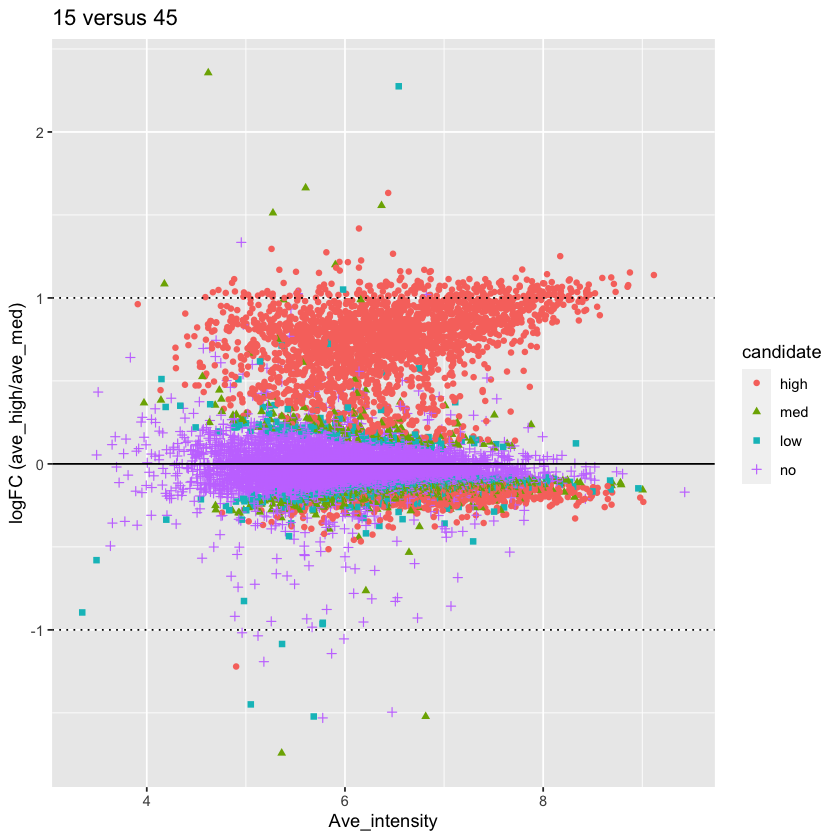

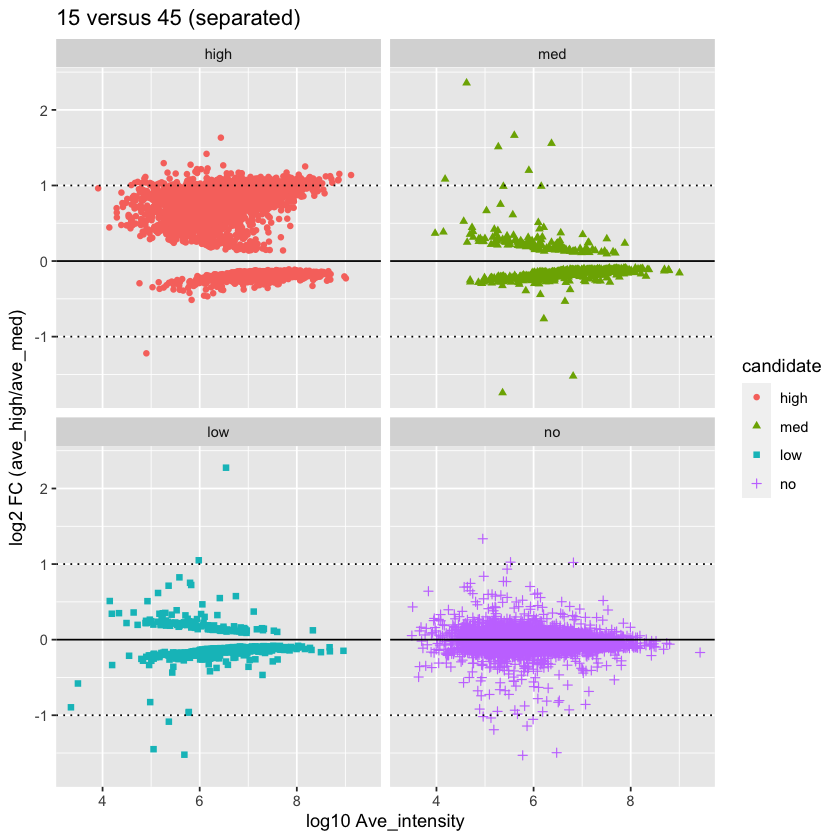

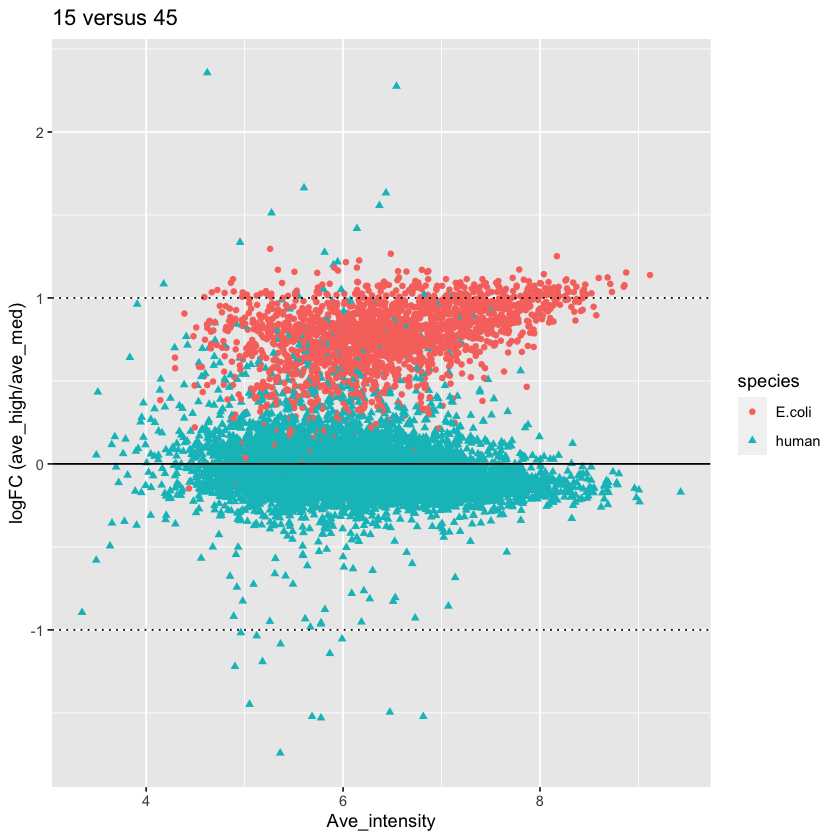

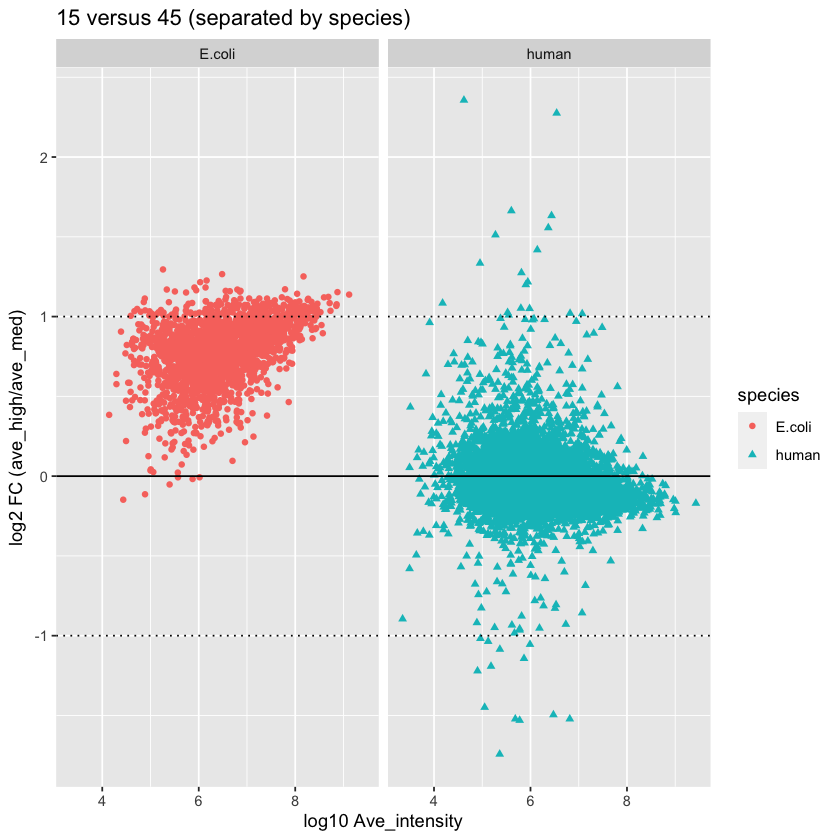

In [24]:
# make MA plots
MA_plots(results, "ave_med", "ave_high", "15 versus 45")
MA_species(results, "ave_med", "ave_high", "15 versus 45")

### Scatter plots

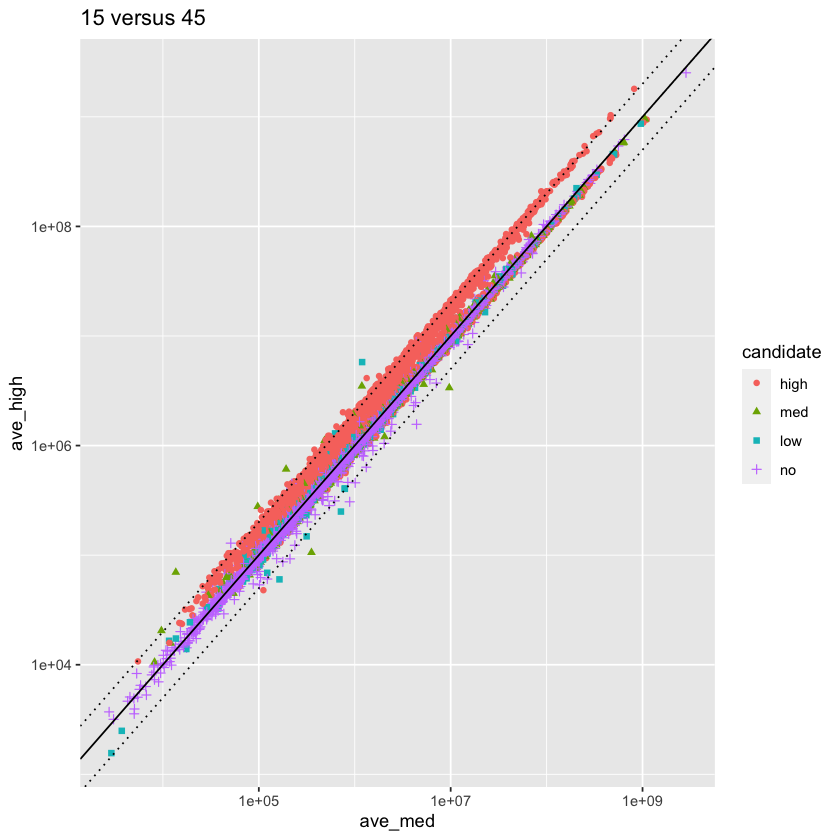

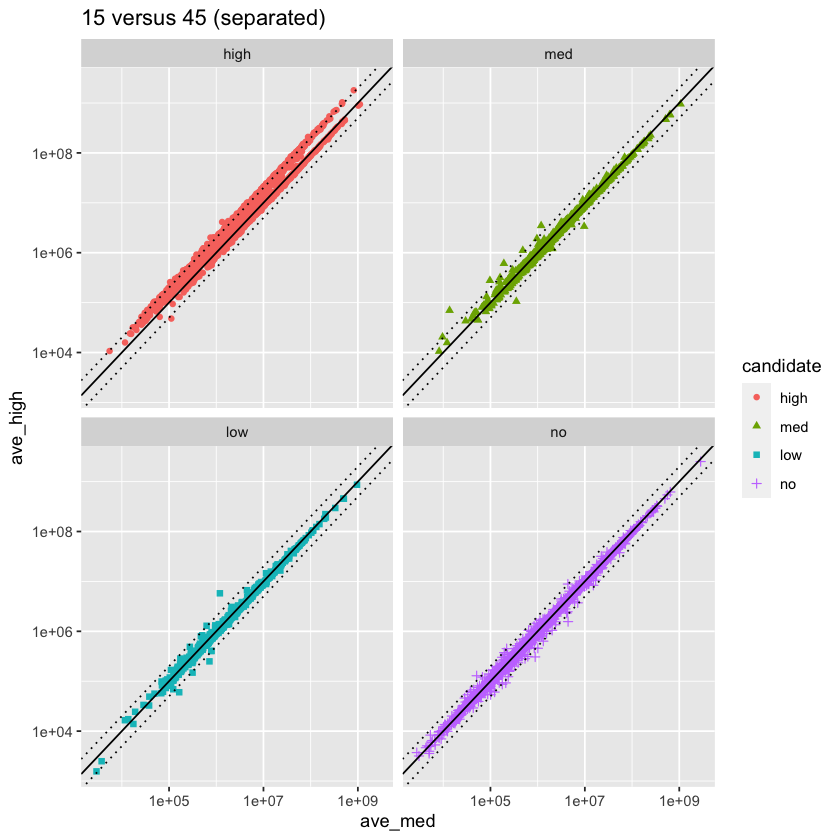

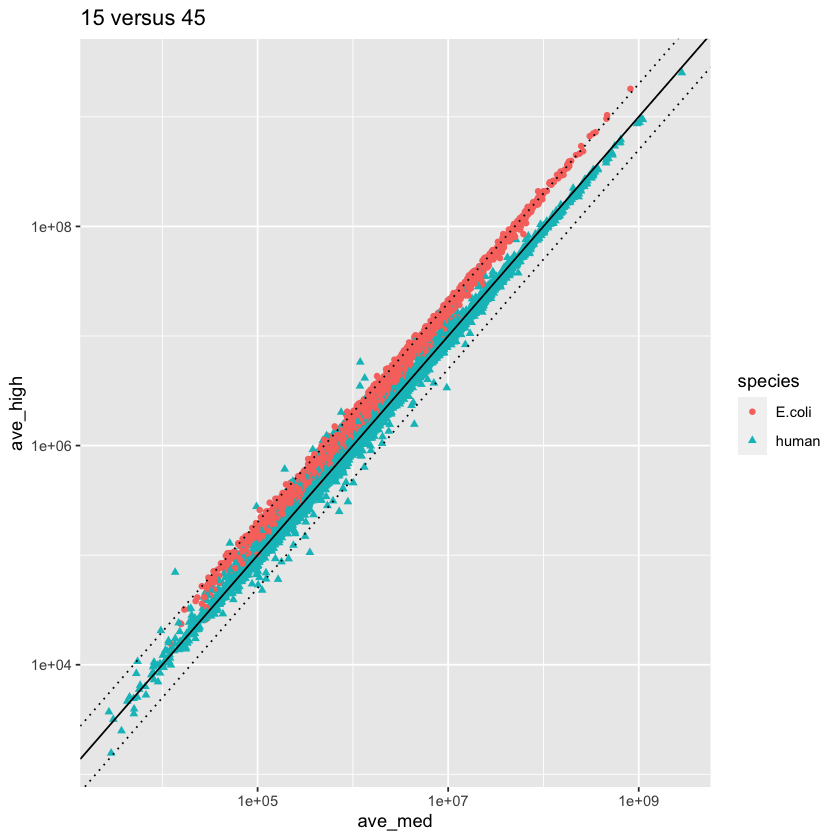

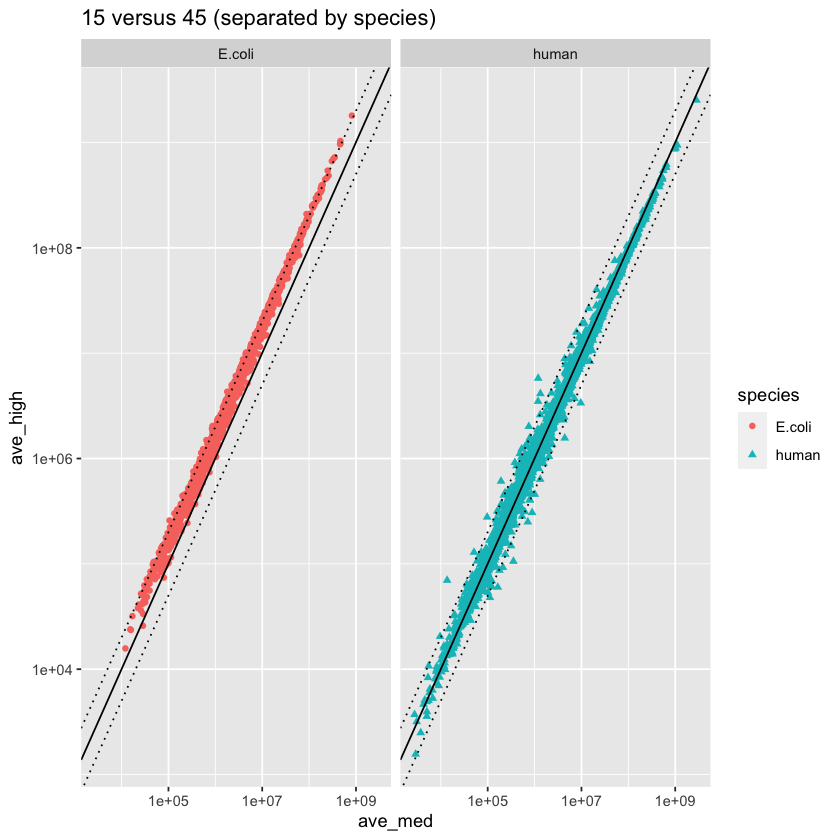

In [25]:
# make scatter plots
scatter_plots(results, "ave_med", "ave_high", "15 versus 45")
scatter_species(results, "ave_med", "ave_high", "15 versus 45")

### Volcano plot

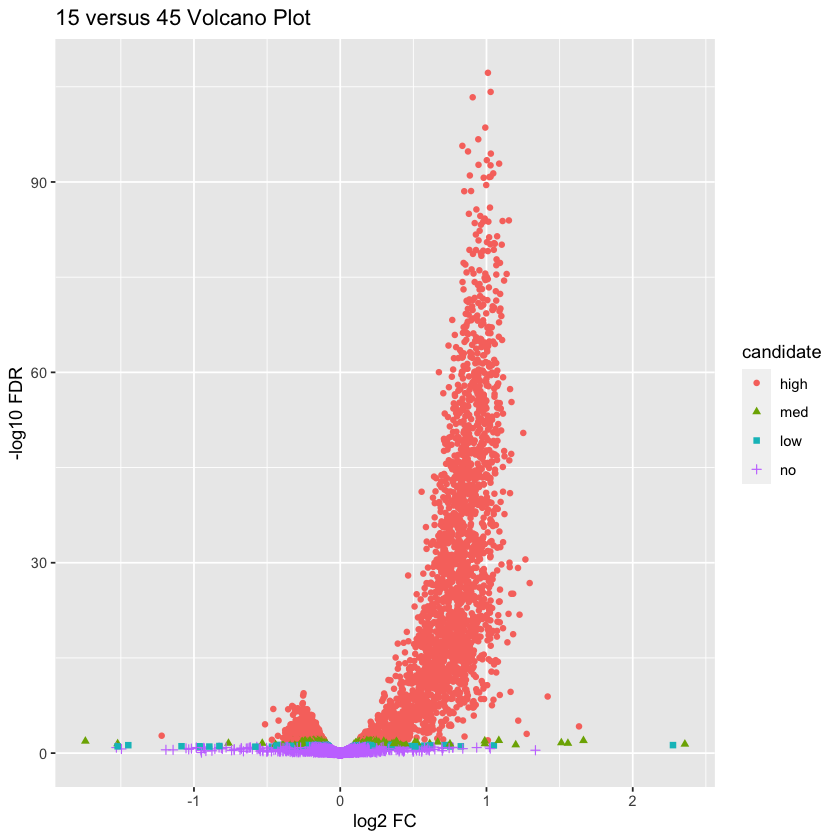

In [26]:
# make a volcano plot
volcano_plot(results, "ave_med", "ave_high", "15 versus 45")

### This really does not look right

We should not have so many down-regulated human proteins. It seems like the normalization did not boost the 45 microgram added channels enough to get the human background leveled out.

### Check individual protein expression

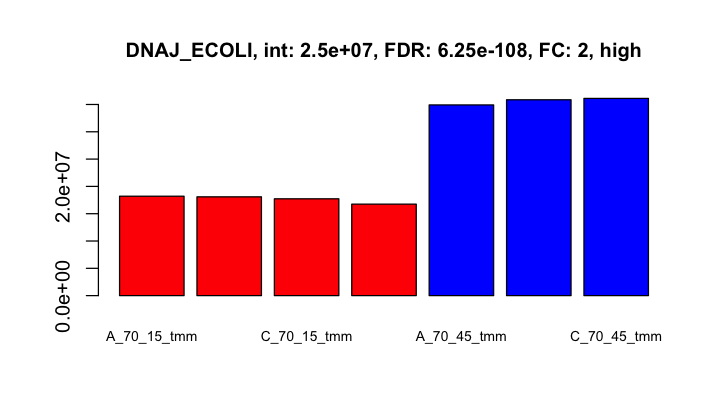

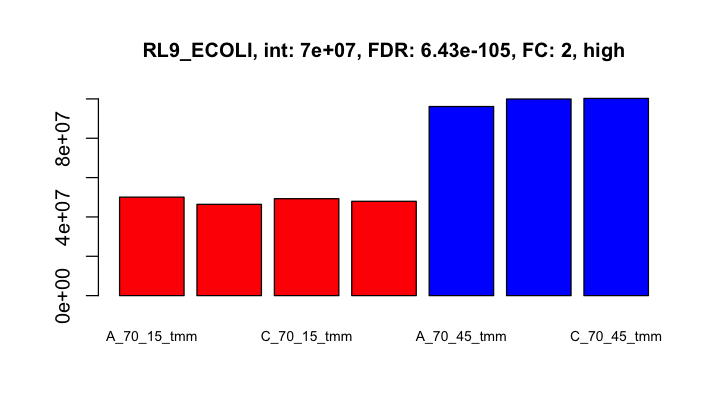

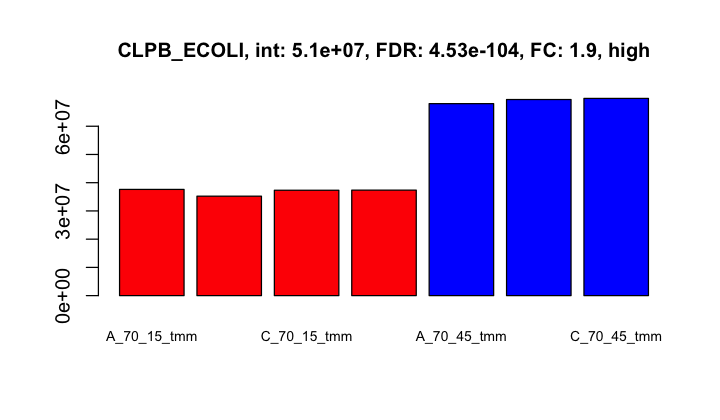

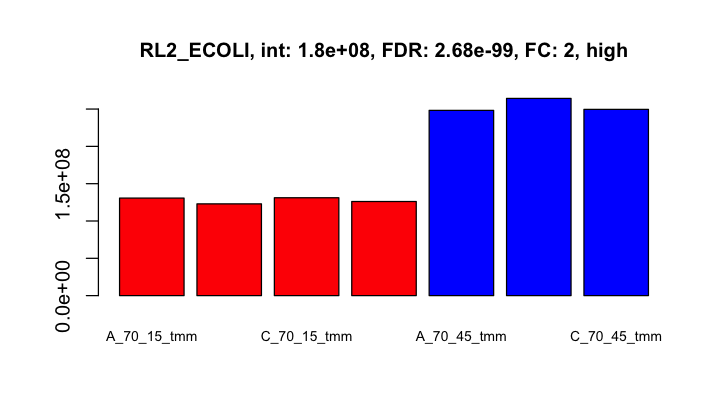

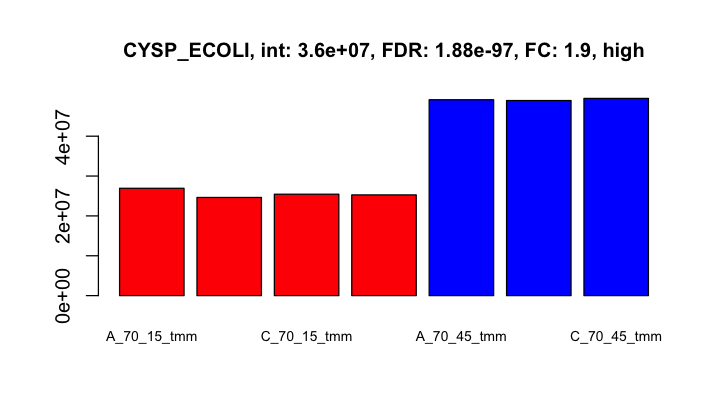

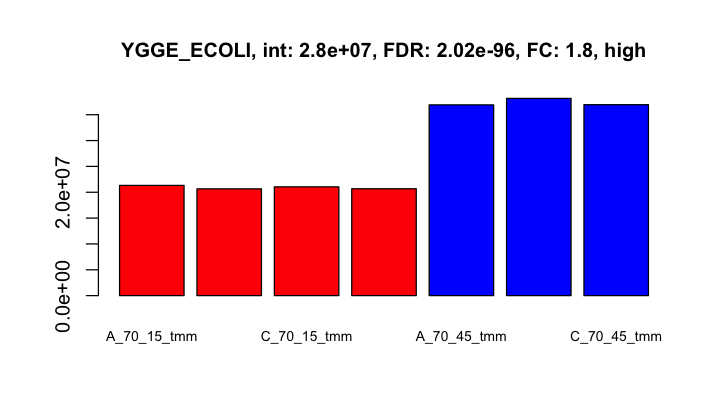

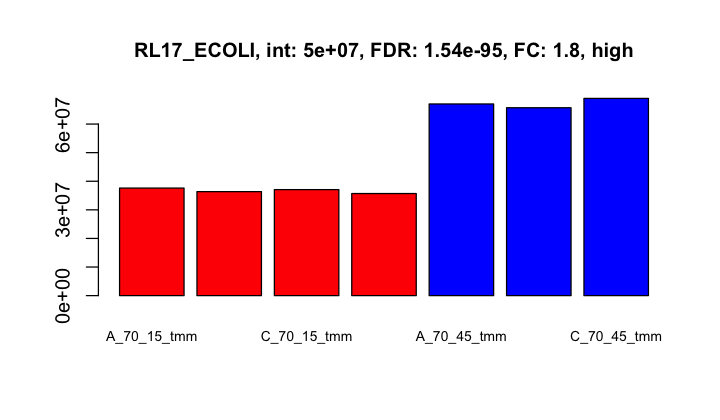

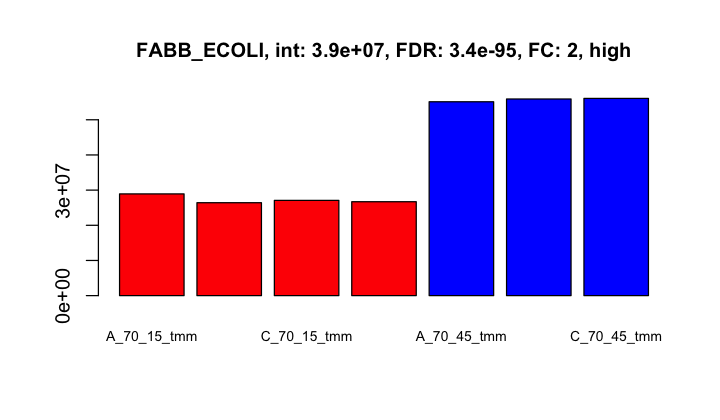

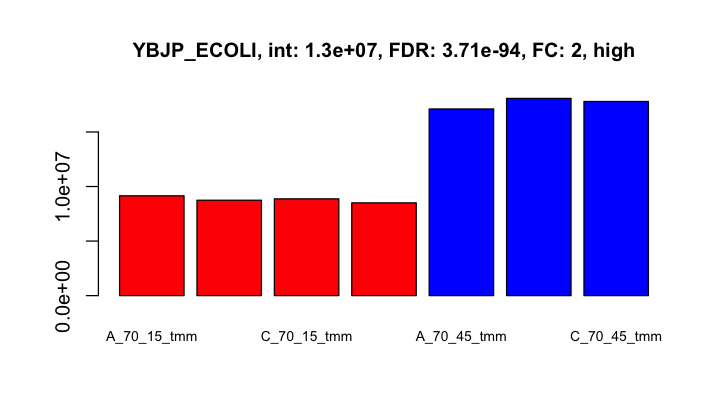

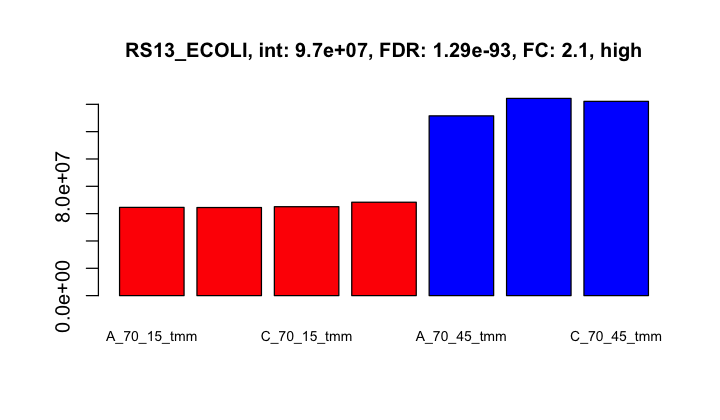

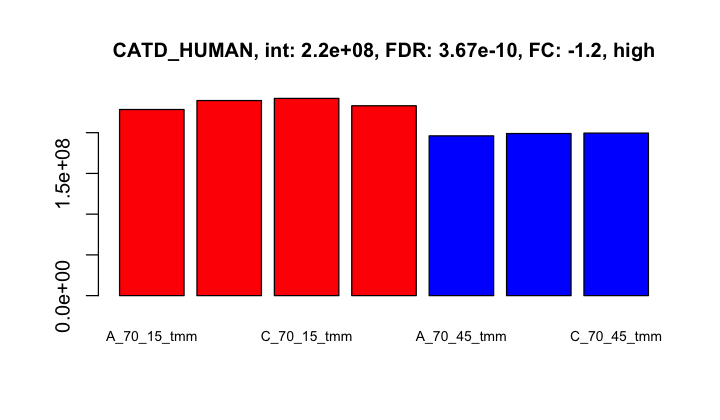

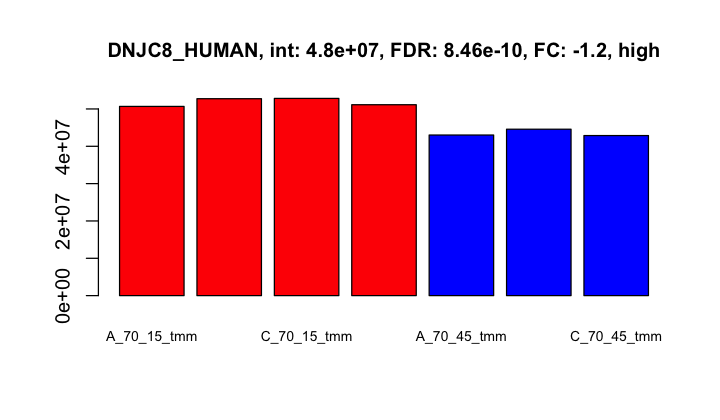

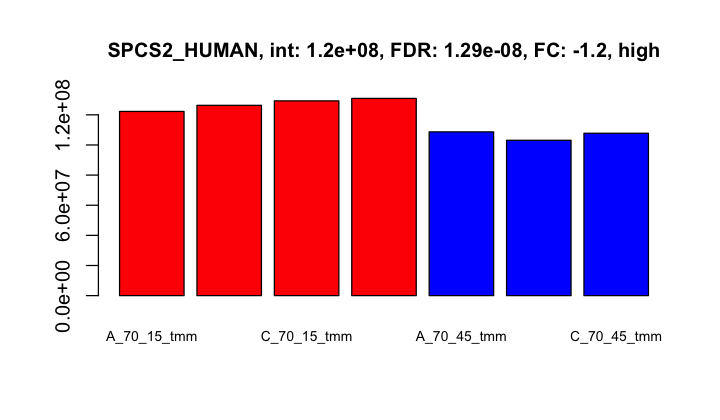

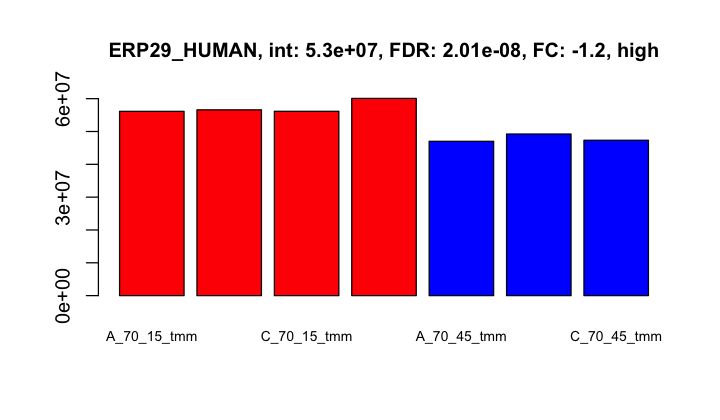

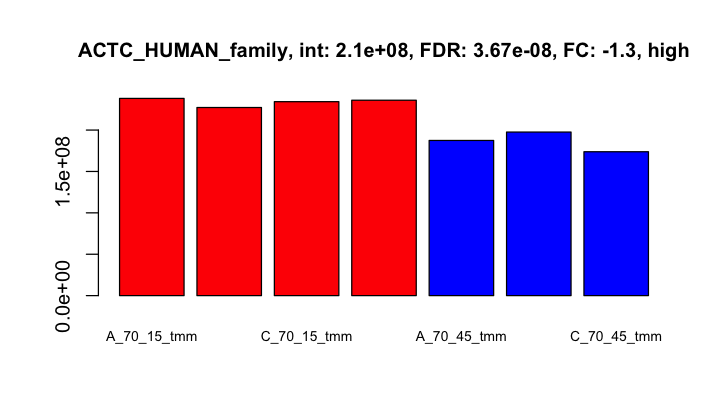

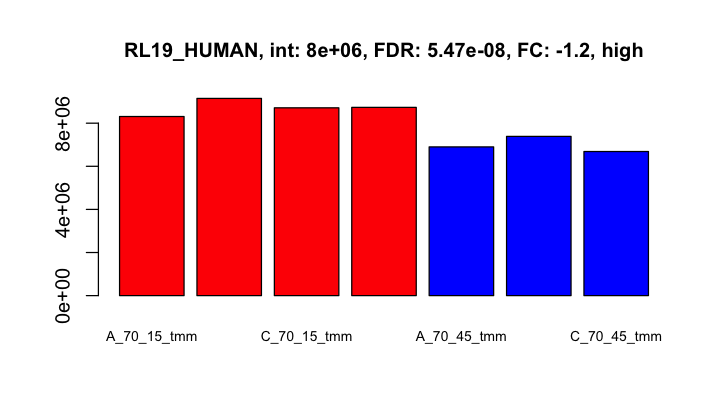

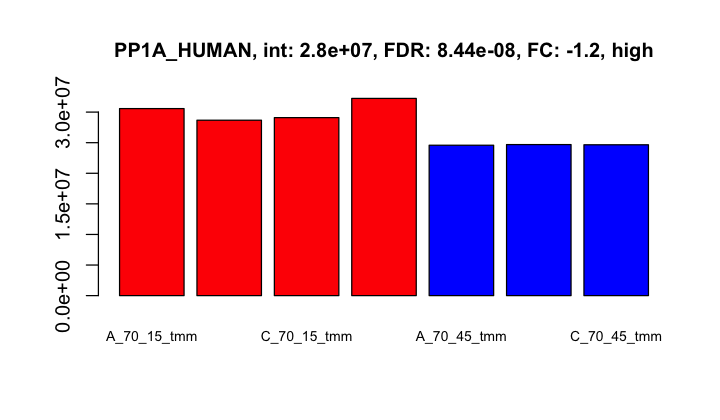

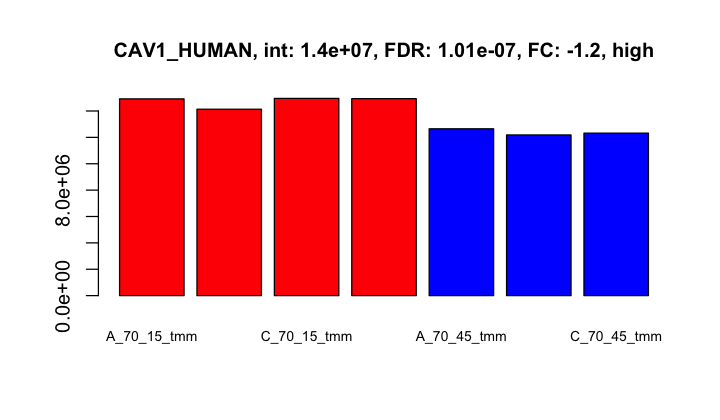

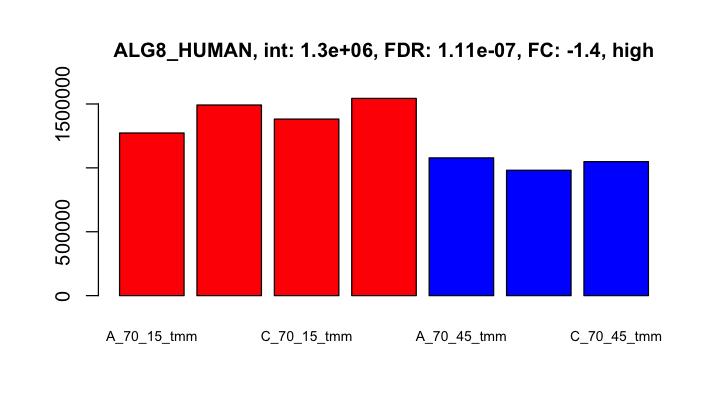

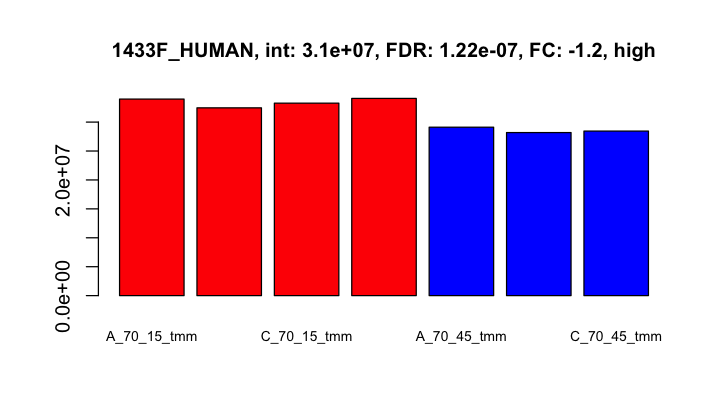

In [27]:
# look at the top candidates
set_plot_dimensions(6, 3.5)
plot_top_tags(results, 4, 3, 10)
set_plot_dimensions(7, 7)

### We have many human DE candidates with -1.2 fold changes

This kind of feels like a normalization artifact (but it is more complicated).

---

## <a name="summary"></a> Summary

Something is wrong here!

---
## Save the `all_results` frame to TSV file

In [28]:
write.table(all_results, "edgeR_TMM_results.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [29]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.9.12.31 edgeR_3.24.3    limma_3.38.3    scales_1.1.0   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_0.8.5     purrr_0.3.3    
 [9] readr_1.3.1     tidyr_1.0.2     tibble_2.1.3    ggplot2_3.3.0  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-40 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.5  reprex_0.3.0    
[13] evaluate